# AutoEncoder for CSC

###  Import and function definition

In [1]:
import pandas as pd
import numpy as np
import math, time, copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from utilities import *
from ResNet import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using:", device)

You are using: cuda


### Loading Data from previous strep

In [2]:
me = "hRHGlobalm3"
out_label = "240724"
data = np.load(me+'_'+out_label+'rebinned_s1.npz')
selected_chamber = data["imgs"]

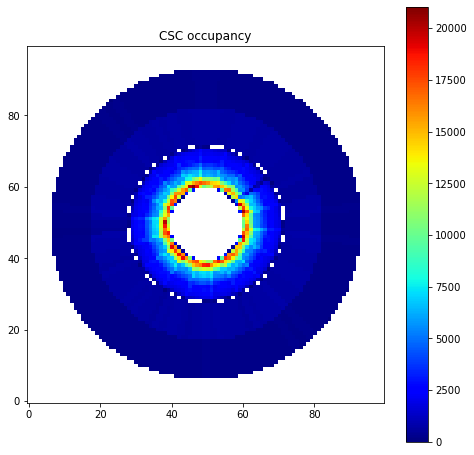

In [3]:
mean_matrix = np.mean(selected_chamber, axis=0)
dim = len(selected_chamber)
Show2Dimg(mean_matrix)
mean_matrix[mean_matrix == 0] = np.nan

In [4]:
tensor_list = [(torch.tensor(m, dtype=torch.float32)).unsqueeze(0) for m in selected_chamber]
print(tensor_list[0].size())
training_dim = int(dim*0.85)
training_tensor = tensor_list[:training_dim]
validation_tensor = tensor_list[training_dim:]
print(f"Data ({len(selected_chamber)}) = Training sample ({len(training_tensor)}) + Validation sample ({len(validation_tensor)})")

torch.Size([1, 100, 100])
Data (2900) = Training sample (2465) + Validation sample (435)


In [5]:
#for k in range(len(validation_tensor)):
#    for i in range(50, 100):
#        for j in range(50, 100):
#            if (i<1.3*j-15 and i>0.7*j+15):
#                validation_tensor[k][0][i][j]=0

In [6]:
training_dataset = TensorDataset(*training_tensor)
validation_dataset = TensorDataset(*validation_tensor)

training_loader = DataLoader(dataset=training_tensor, 
                             batch_size=64, 
                             num_workers=10, 
                             shuffle=True)

validation_loader = DataLoader(dataset=validation_tensor, 
                               batch_size=32,
                               num_workers=10, 
                               shuffle=False)

### Training Loop

In [7]:
img_size = list(tensor_list[0].squeeze(0).size())
ae = ResNetAE(1, 3, [16, 32, 64], img_size=img_size).to(device)
optimizer = optim.Adam(ae.parameters(), lr=5.e-4)
train_loss, val_loss =[], []
epochs = 50
for e in range(epochs):
    epoch = e+1
    print(f'***** Training Epoch {epoch} *****')
    # Run training
    ae.train()
    now = time.time()
    tloss=[]
    for i, figure in enumerate(training_loader):
        X = figure.to(device)
        #X = X
        optimizer.zero_grad()
        Xreco = ae(X)
        
        #if i==1:
        #    PLots_in_training(X, Xreco)
        #print(X)
        #loss = F.l1_loss(Xreco, X)
        #loss = F.mse_loss(Xreco, X) smooth_l1_loss
        loss = F.l1_loss(Xreco, X)
        tloss.append(loss.item())
        loss.backward()
        optimizer.step()
        if i%4 ==0:
            print(f'>> [{i}/{len(training_loader)}] Train loss:{loss.item()}')
    train_loss.append(np.mean(tloss))
    now = time.time() - now
    s = '>> Training time: %.2f min in %d steps'%( now/60, len(training_loader))
    print(s)

***** Training Epoch 1 *****
>> [0/39] Train loss:748.3192138671875
>> [4/39] Train loss:700.6644287109375
>> [8/39] Train loss:592.1799926757812
>> [12/39] Train loss:526.2073974609375
>> [16/39] Train loss:505.2889404296875
>> [20/39] Train loss:461.5289001464844
>> [24/39] Train loss:434.0013427734375
>> [28/39] Train loss:400.4114990234375
>> [32/39] Train loss:378.4168701171875
>> [36/39] Train loss:360.8504943847656
>> Training time: 0.22 min in 39 steps
***** Training Epoch 2 *****
>> [0/39] Train loss:325.8437194824219
>> [4/39] Train loss:326.64678955078125
>> [8/39] Train loss:300.2615051269531
>> [12/39] Train loss:294.521240234375
>> [16/39] Train loss:283.06719970703125
>> [20/39] Train loss:263.30023193359375
>> [24/39] Train loss:246.97337341308594
>> [28/39] Train loss:246.86831665039062
>> [32/39] Train loss:241.85385131835938
>> [36/39] Train loss:241.8574981689453
>> Training time: 0.06 min in 39 steps
***** Training Epoch 3 *****
>> [0/39] Train loss:238.58404541015

>> [20/39] Train loss:162.09951782226562
>> [24/39] Train loss:165.7210235595703
>> [28/39] Train loss:154.21876525878906
>> [32/39] Train loss:163.7812042236328
>> [36/39] Train loss:178.3176727294922
>> Training time: 0.06 min in 39 steps
***** Training Epoch 19 *****
>> [0/39] Train loss:164.6971893310547
>> [4/39] Train loss:155.2745361328125
>> [8/39] Train loss:164.00180053710938
>> [12/39] Train loss:164.0750732421875
>> [16/39] Train loss:165.3543701171875
>> [20/39] Train loss:157.79417419433594
>> [24/39] Train loss:159.10617065429688
>> [28/39] Train loss:156.51025390625
>> [32/39] Train loss:163.0793914794922
>> [36/39] Train loss:164.25709533691406
>> Training time: 0.06 min in 39 steps
***** Training Epoch 20 *****
>> [0/39] Train loss:164.9451904296875
>> [4/39] Train loss:154.70343017578125
>> [8/39] Train loss:158.2562255859375
>> [12/39] Train loss:162.7841033935547
>> [16/39] Train loss:165.05960083007812
>> [20/39] Train loss:154.10430908203125
>> [24/39] Train loss

>> [0/39] Train loss:160.8759765625
>> [4/39] Train loss:160.06639099121094
>> [8/39] Train loss:155.45098876953125
>> [12/39] Train loss:151.57302856445312
>> [16/39] Train loss:158.6084747314453
>> [20/39] Train loss:159.43783569335938
>> [24/39] Train loss:156.71656799316406
>> [28/39] Train loss:152.66632080078125
>> [32/39] Train loss:157.7757568359375
>> [36/39] Train loss:164.34231567382812
>> Training time: 0.06 min in 39 steps
***** Training Epoch 37 *****
>> [0/39] Train loss:160.02682495117188
>> [4/39] Train loss:158.21119689941406
>> [8/39] Train loss:150.45176696777344
>> [12/39] Train loss:159.6560516357422
>> [16/39] Train loss:156.13870239257812
>> [20/39] Train loss:164.57102966308594
>> [24/39] Train loss:164.06161499023438
>> [28/39] Train loss:161.91378784179688
>> [32/39] Train loss:159.01490783691406
>> [36/39] Train loss:156.5210418701172
>> Training time: 0.06 min in 39 steps
***** Training Epoch 38 *****
>> [0/39] Train loss:155.84120178222656
>> [4/39] Train 

### Validation dataset

In [8]:
torch.save(ae, "model_"+out_label+".pth")
#model = torch.load("model_"+out_label+".pth")

***** batch 0 *****
 >> Example 0
 >> Original image:


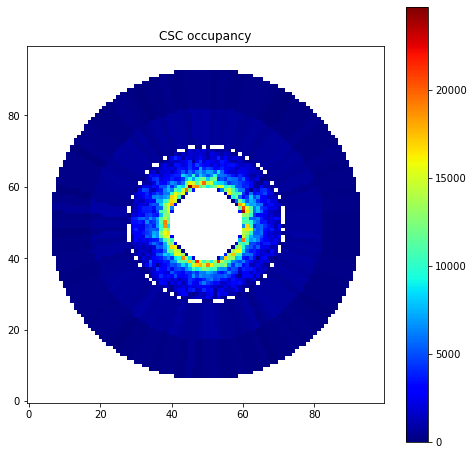

 >> AE-reco image:


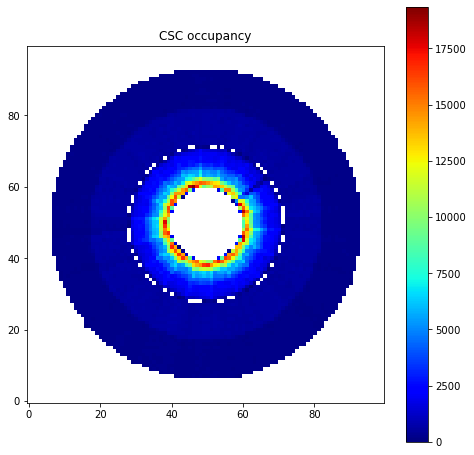

 >> Normalized loss map:


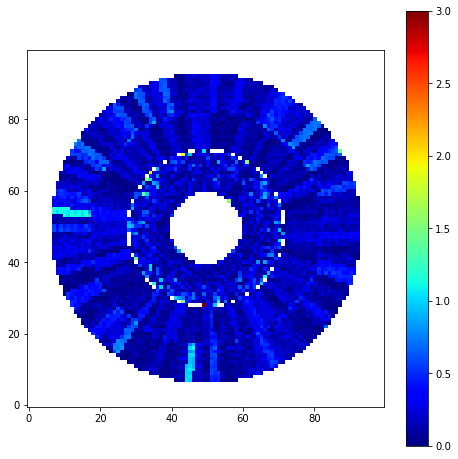

 >> Example 1
 >> Original image:


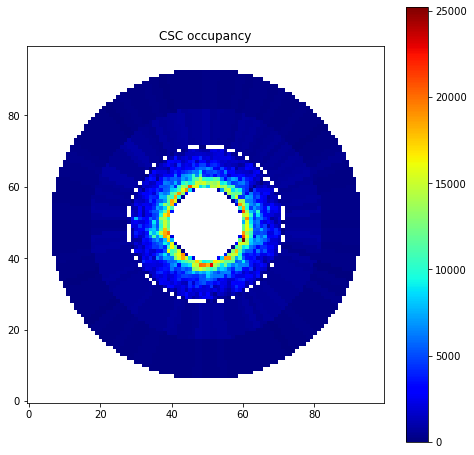

 >> AE-reco image:


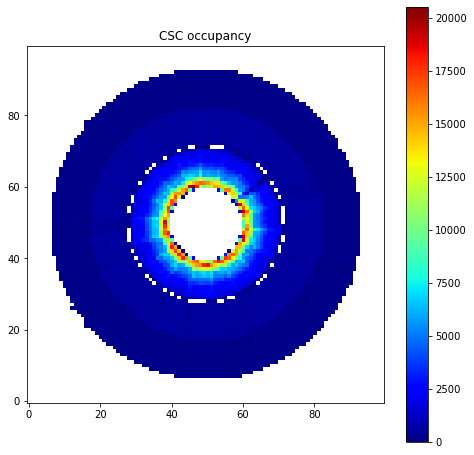

 >> Normalized loss map:


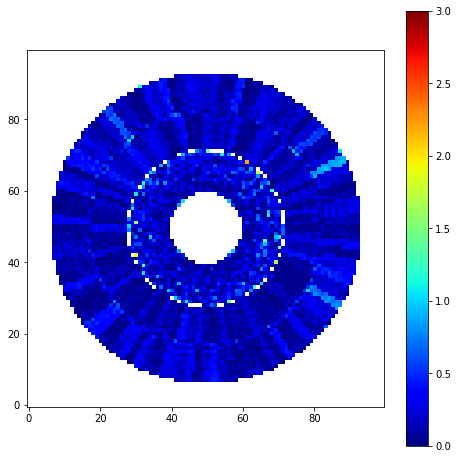

 >> Example 2
 >> Original image:


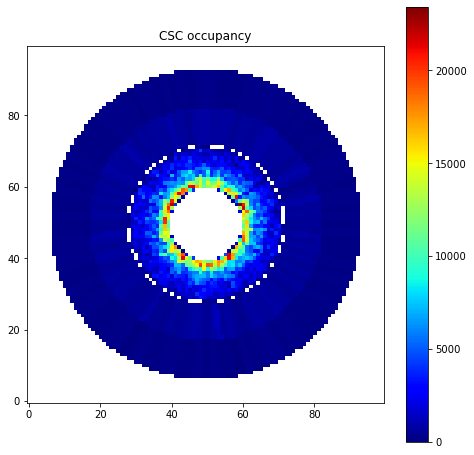

 >> AE-reco image:


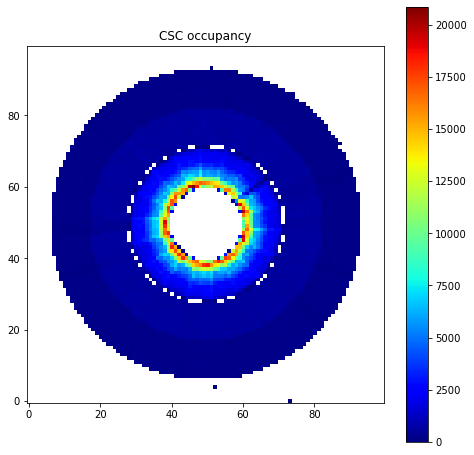

 >> Normalized loss map:


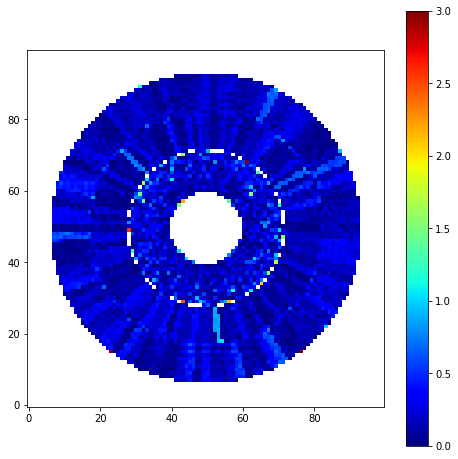

 >> Example 3
 >> Original image:


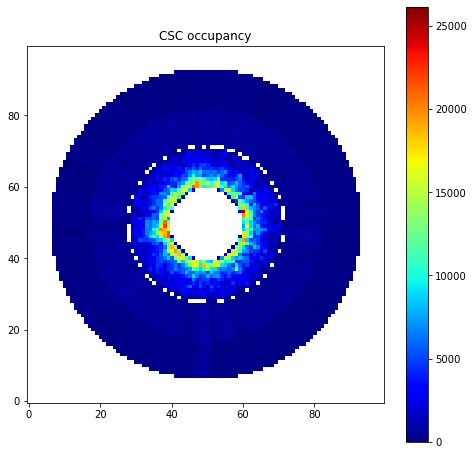

 >> AE-reco image:


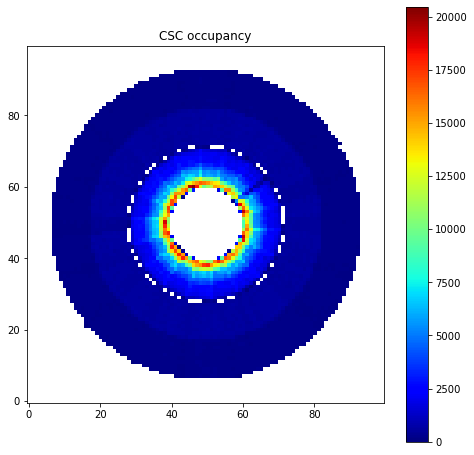

 >> Normalized loss map:


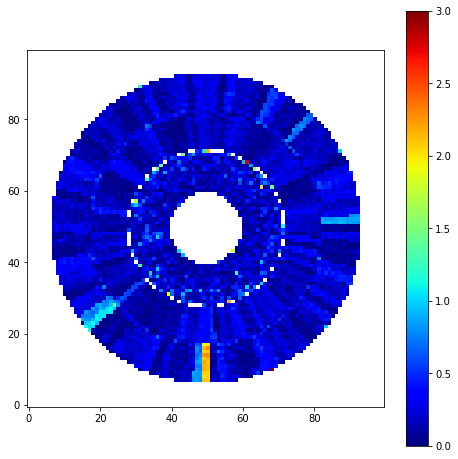

***** batch 1 *****
 >> Example 0
 >> Original image:


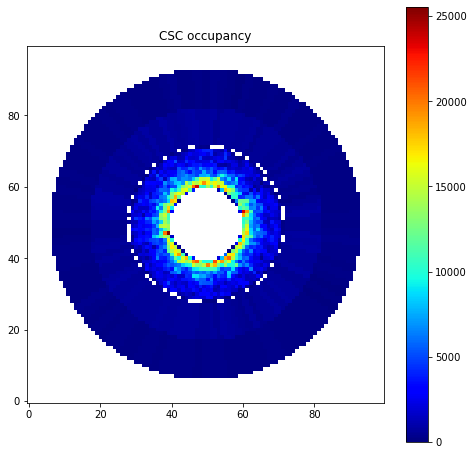

 >> AE-reco image:


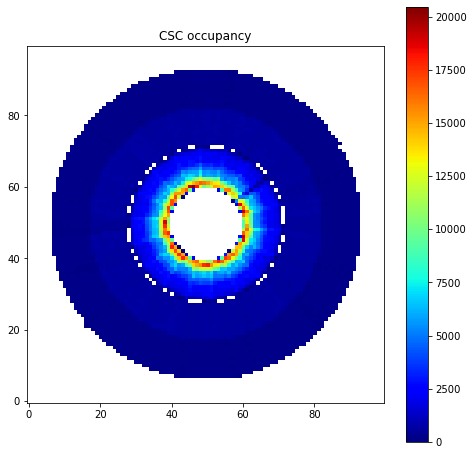

 >> Normalized loss map:


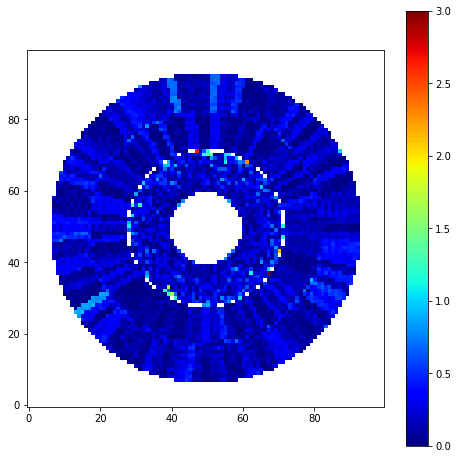

 >> Example 1
 >> Original image:


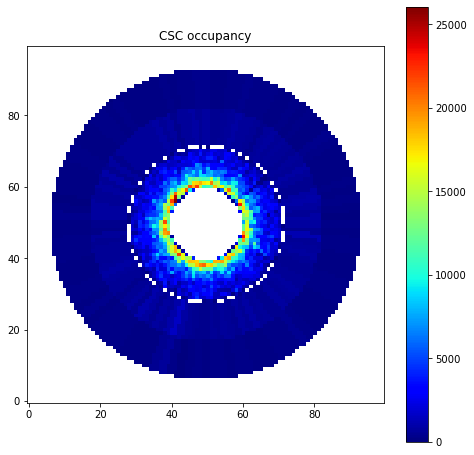

 >> AE-reco image:


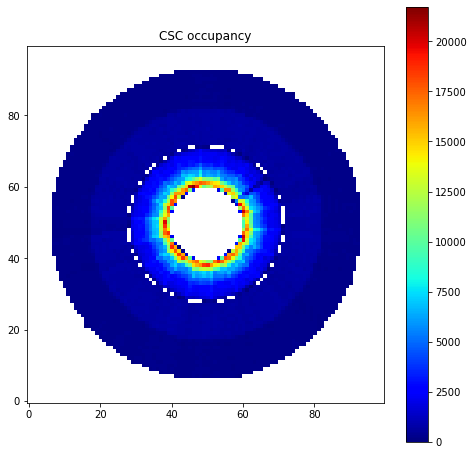

 >> Normalized loss map:


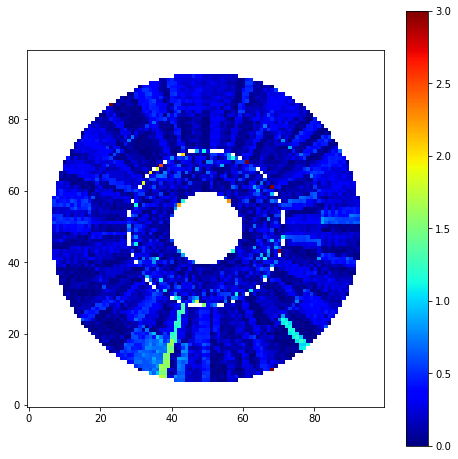

 >> Example 2
 >> Original image:


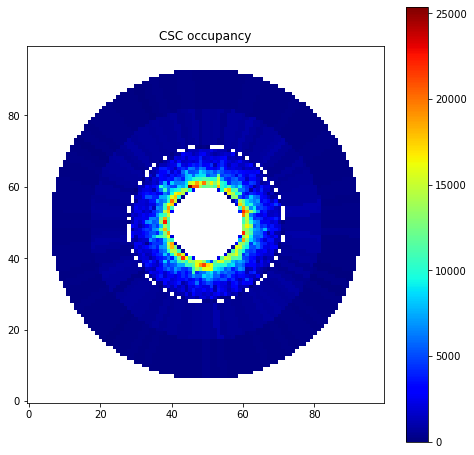

 >> AE-reco image:


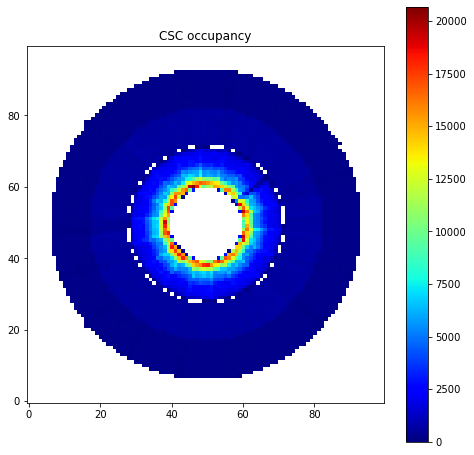

 >> Normalized loss map:


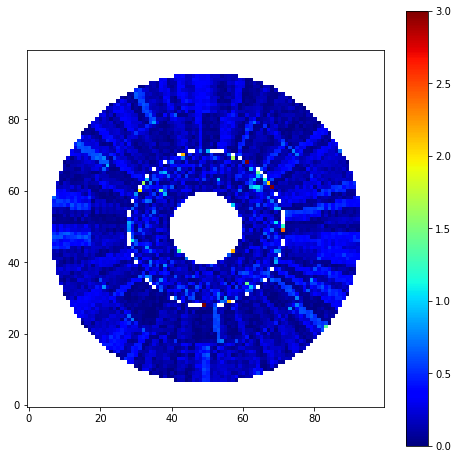

 >> Example 3
 >> Original image:


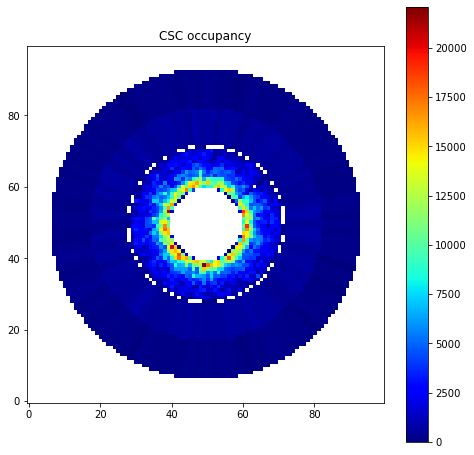

 >> AE-reco image:


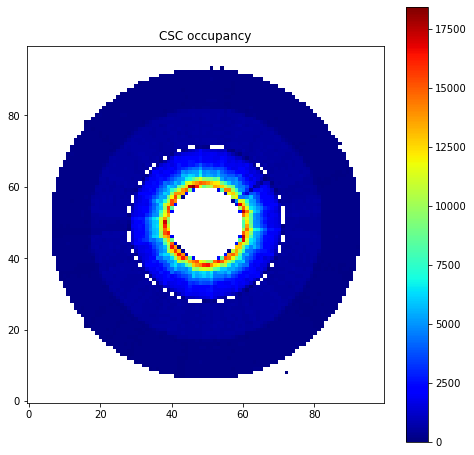

 >> Normalized loss map:


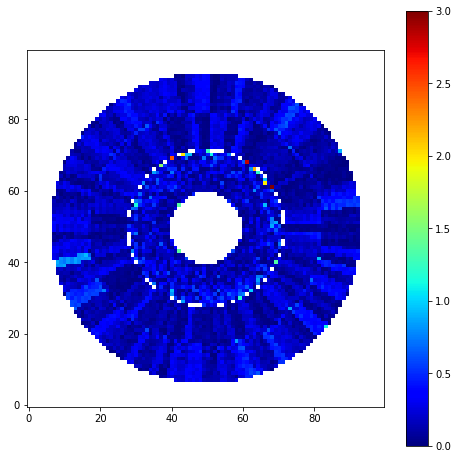

***** batch 2 *****
 >> Example 0
 >> Original image:


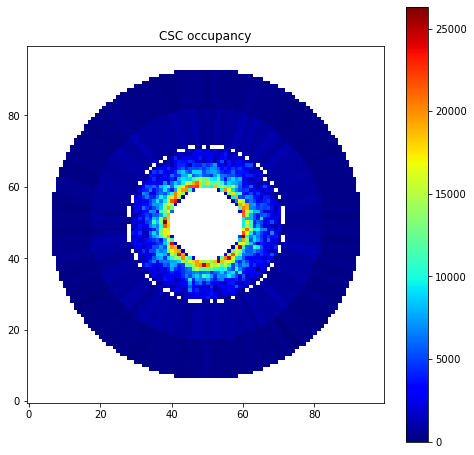

 >> AE-reco image:


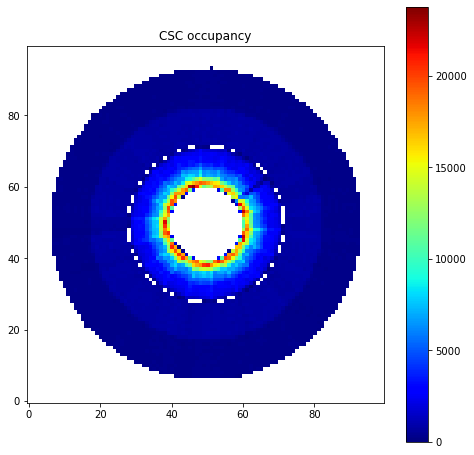

 >> Normalized loss map:


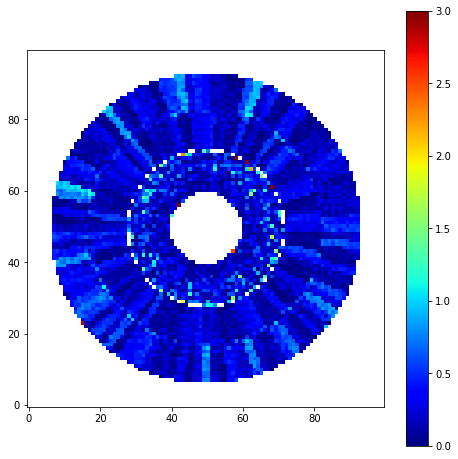

 >> Example 1
 >> Original image:


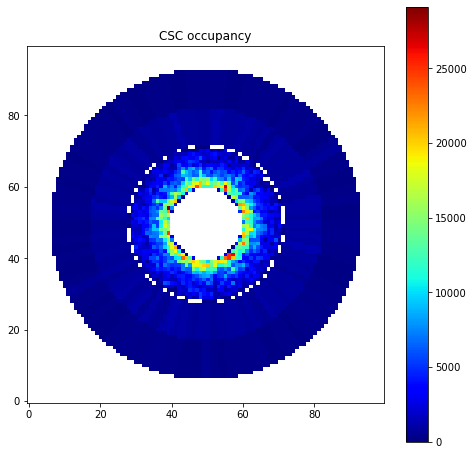

 >> AE-reco image:


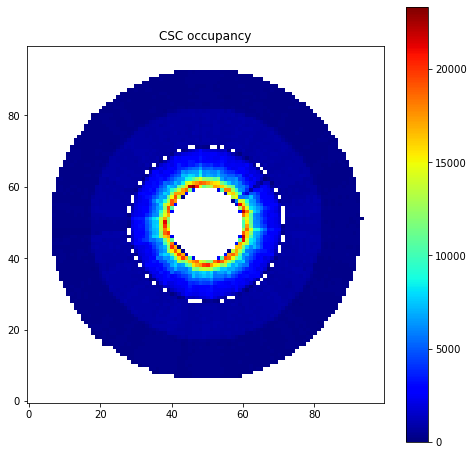

 >> Normalized loss map:


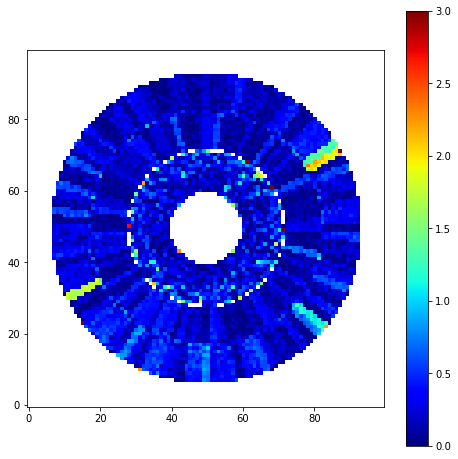

 >> Example 2
 >> Original image:


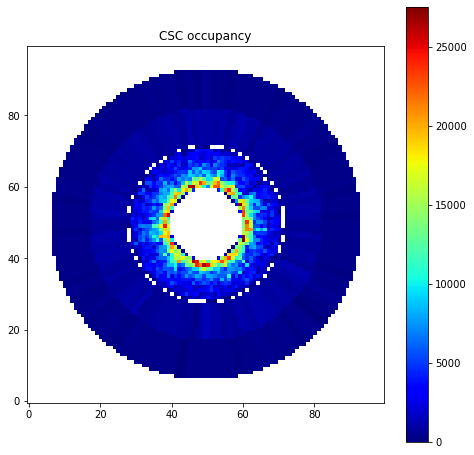

 >> AE-reco image:


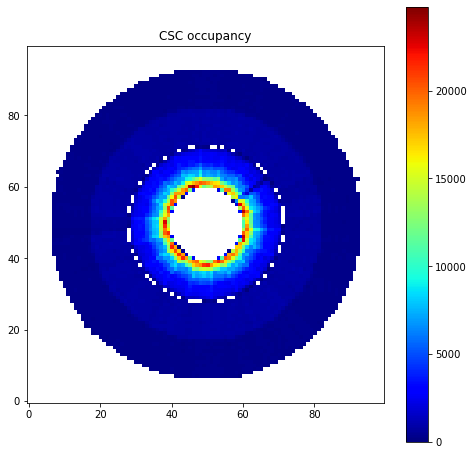

 >> Normalized loss map:


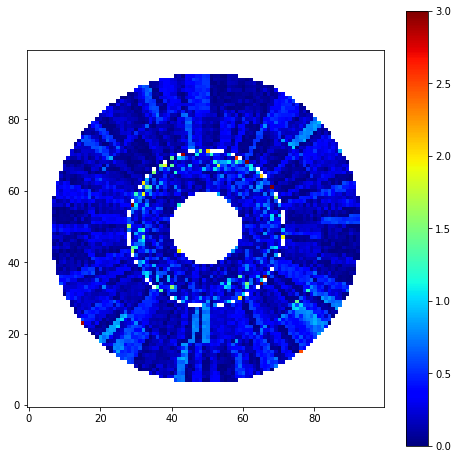

 >> Example 3
 >> Original image:


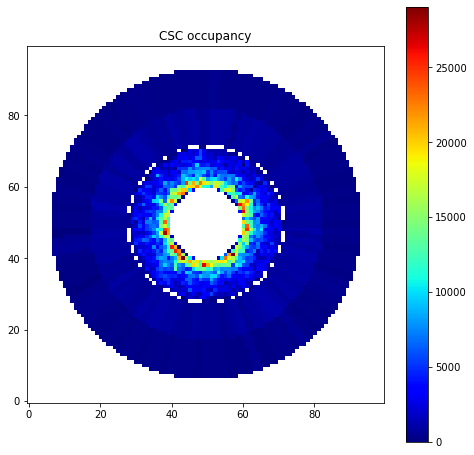

 >> AE-reco image:


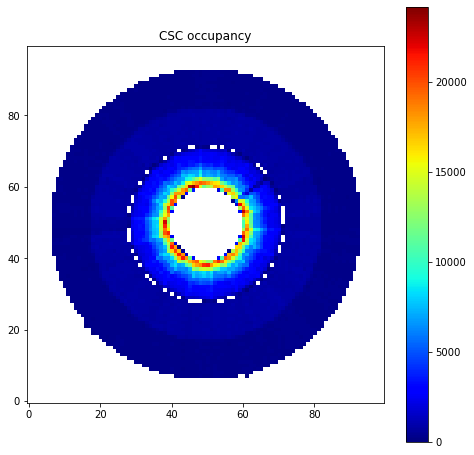

 >> Normalized loss map:


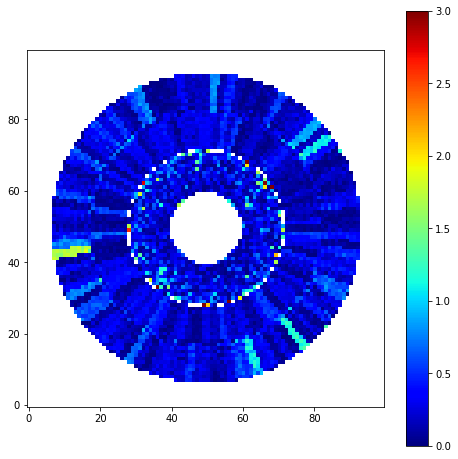

***** batch 3 *****
 >> Example 0
 >> Original image:


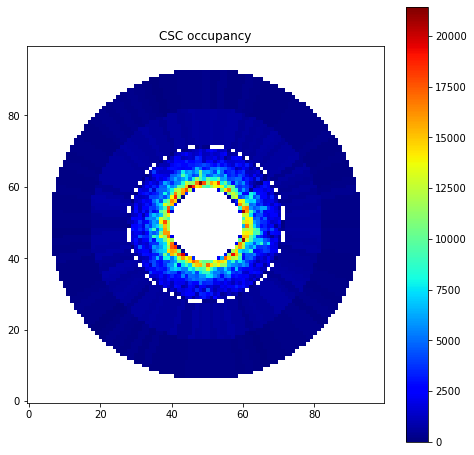

 >> AE-reco image:


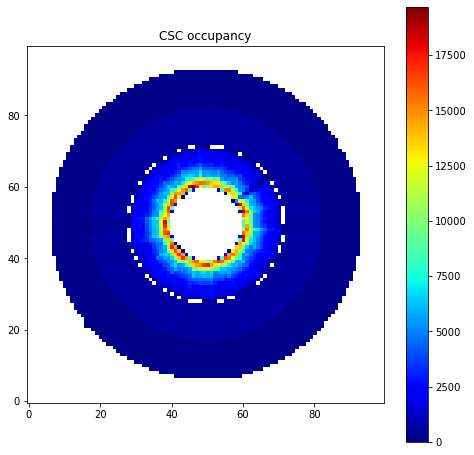

 >> Normalized loss map:


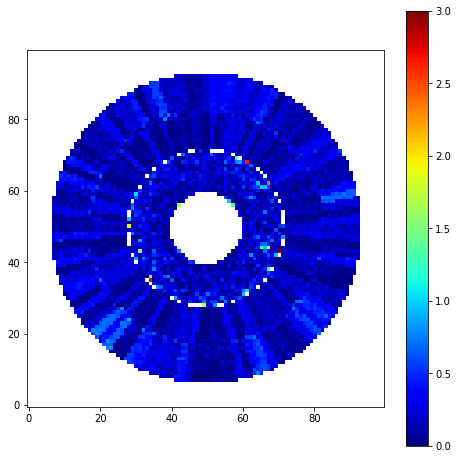

 >> Example 1
 >> Original image:


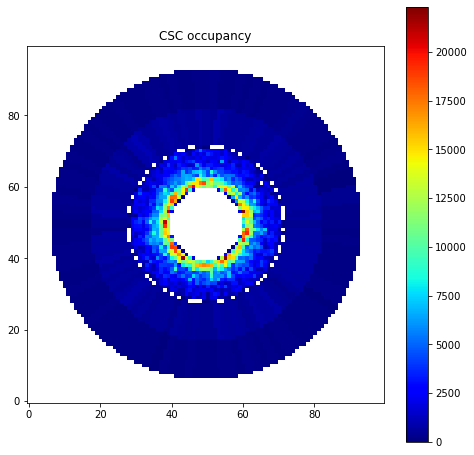

 >> AE-reco image:


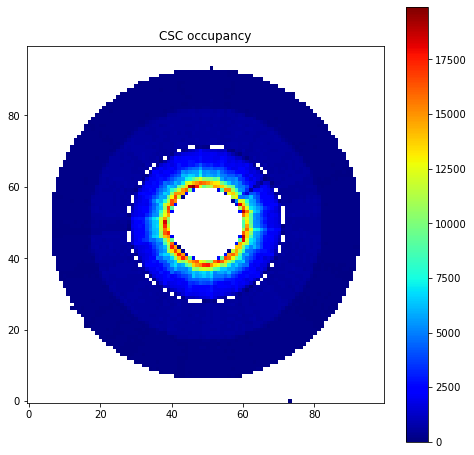

 >> Normalized loss map:


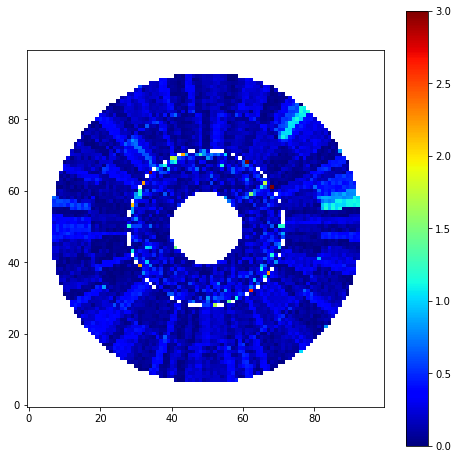

 >> Example 2
 >> Original image:


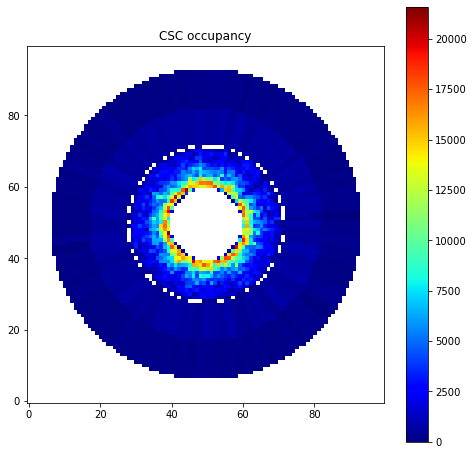

 >> AE-reco image:


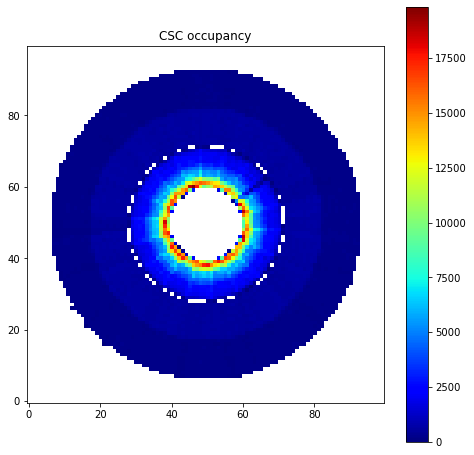

 >> Normalized loss map:


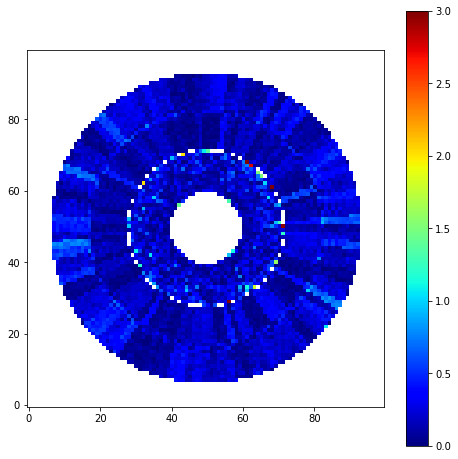

 >> Example 3
 >> Original image:


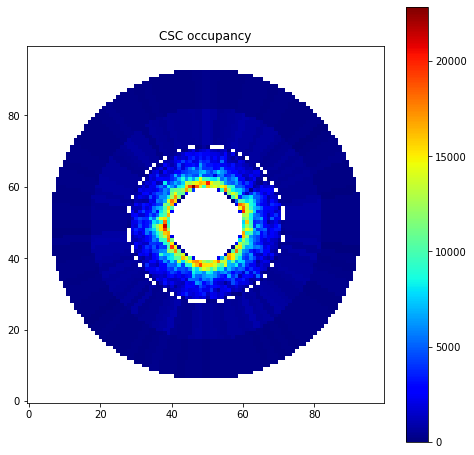

 >> AE-reco image:


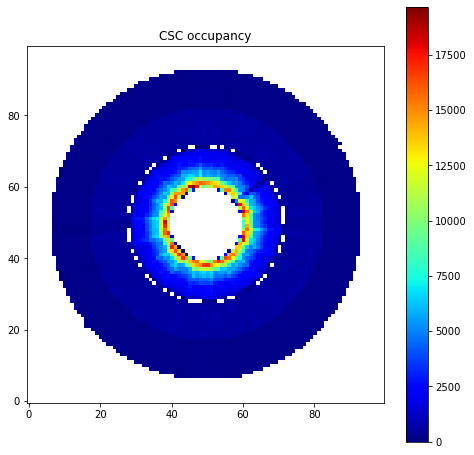

 >> Normalized loss map:


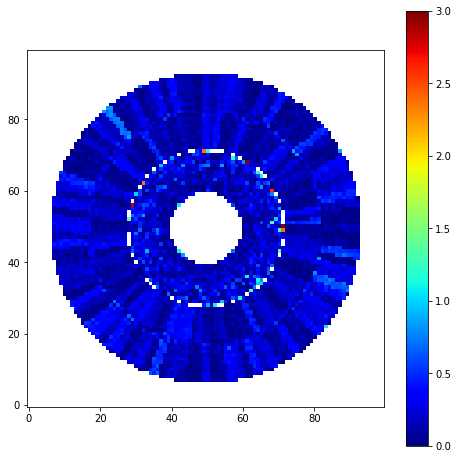

***** batch 4 *****
 >> Example 0
 >> Original image:


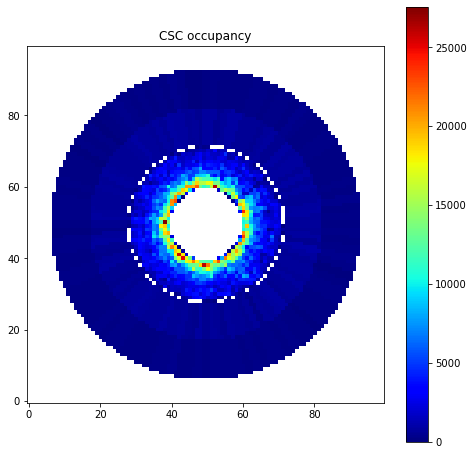

 >> AE-reco image:


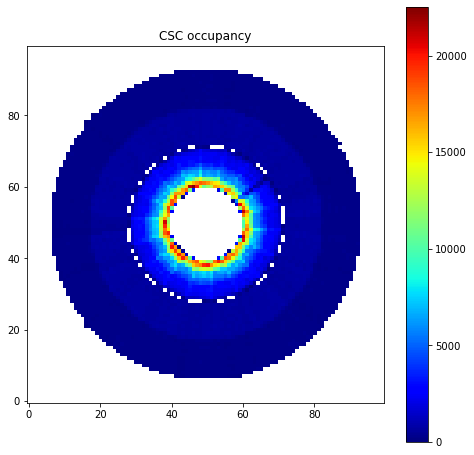

 >> Normalized loss map:


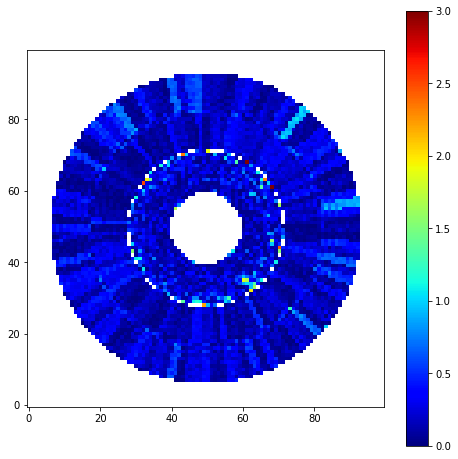

 >> Example 1
 >> Original image:


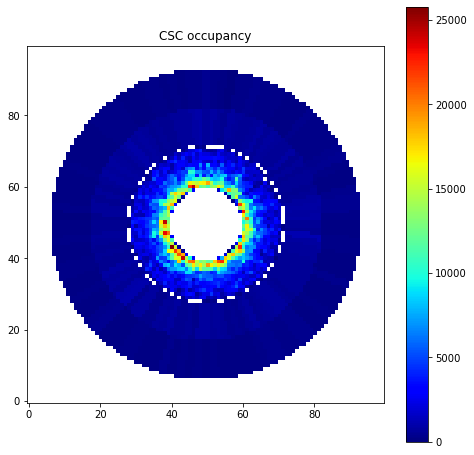

 >> AE-reco image:


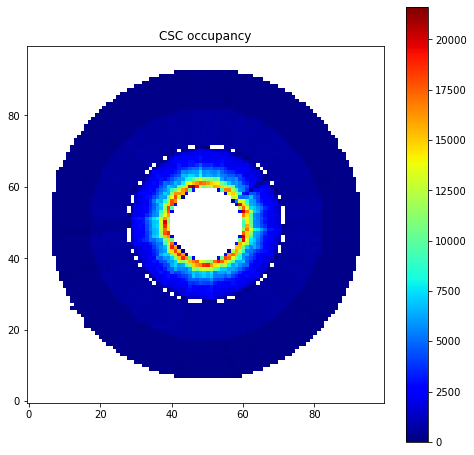

 >> Normalized loss map:


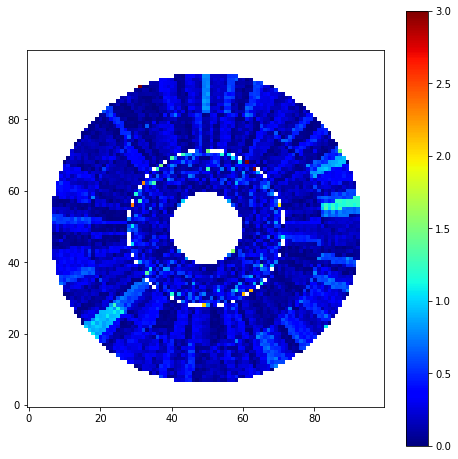

 >> Example 2
 >> Original image:


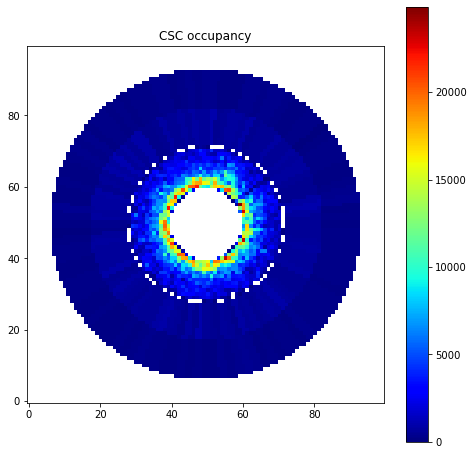

 >> AE-reco image:


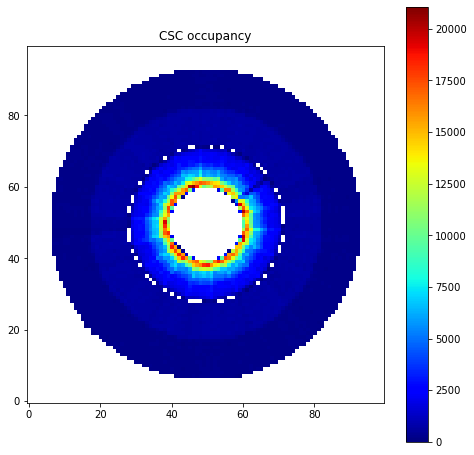

 >> Normalized loss map:


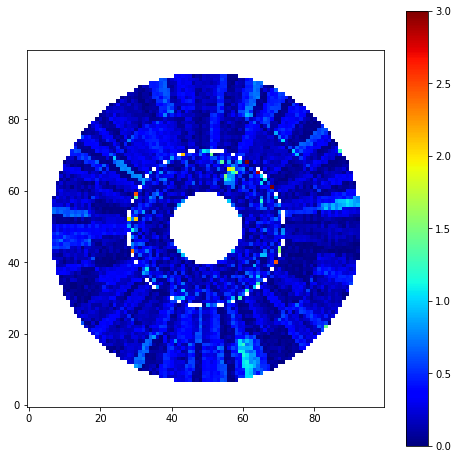

 >> Example 3
 >> Original image:


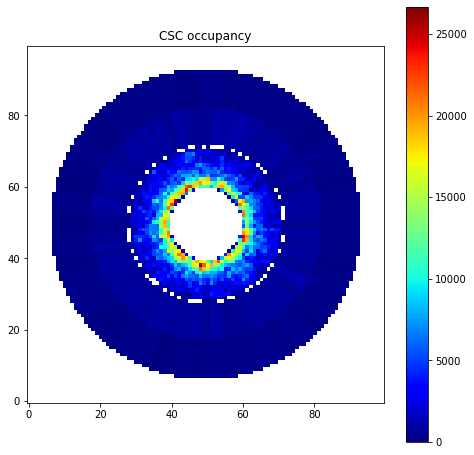

 >> AE-reco image:


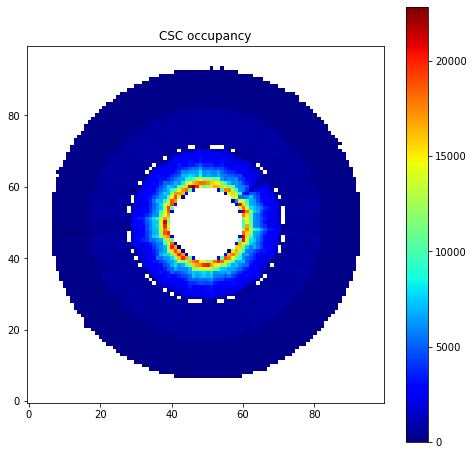

 >> Normalized loss map:


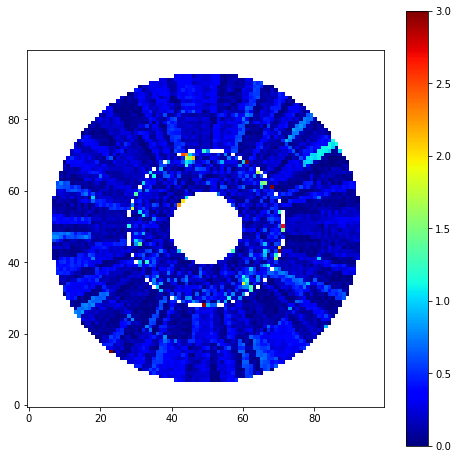

***** batch 5 *****
 >> Example 0
 >> Original image:


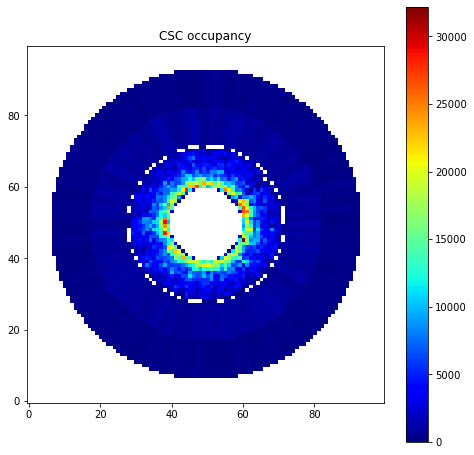

 >> AE-reco image:


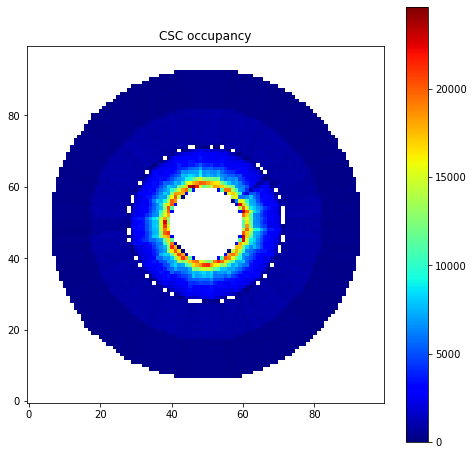

 >> Normalized loss map:


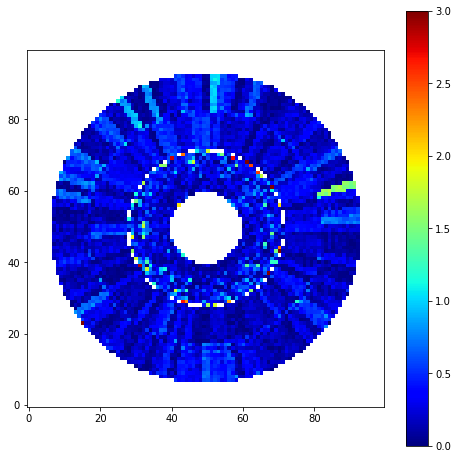

 >> Example 1
 >> Original image:


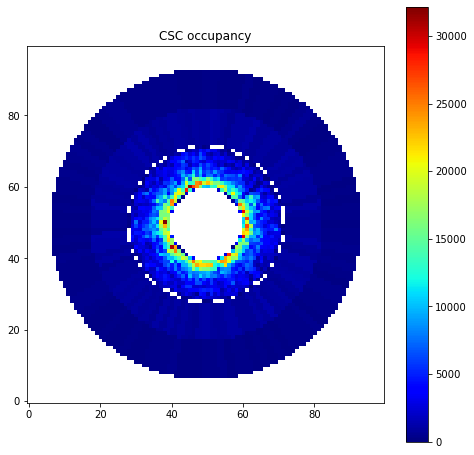

 >> AE-reco image:


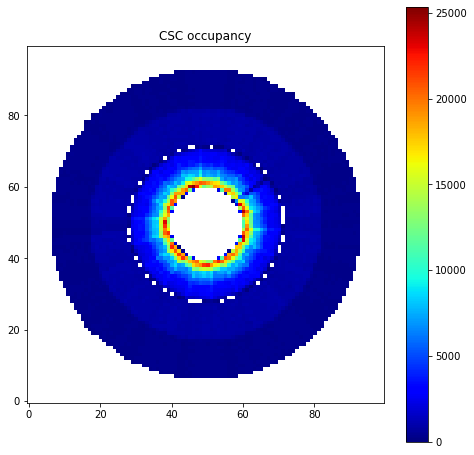

 >> Normalized loss map:


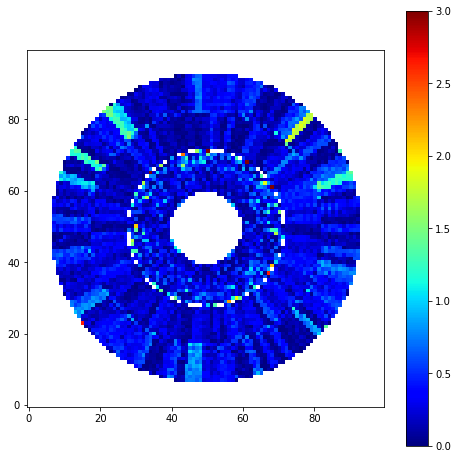

 >> Example 2
 >> Original image:


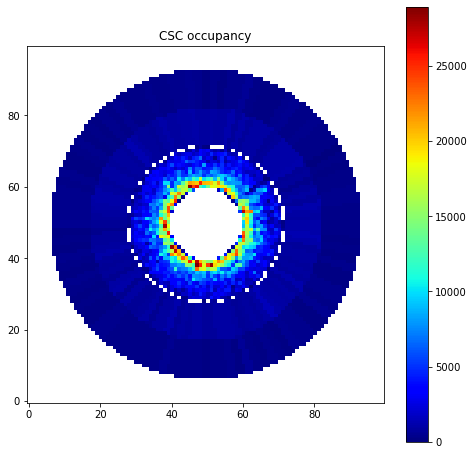

 >> AE-reco image:


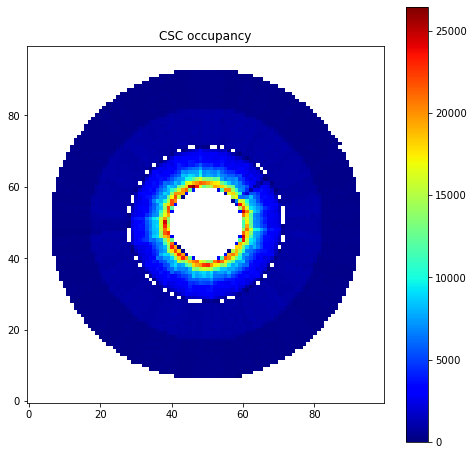

 >> Normalized loss map:


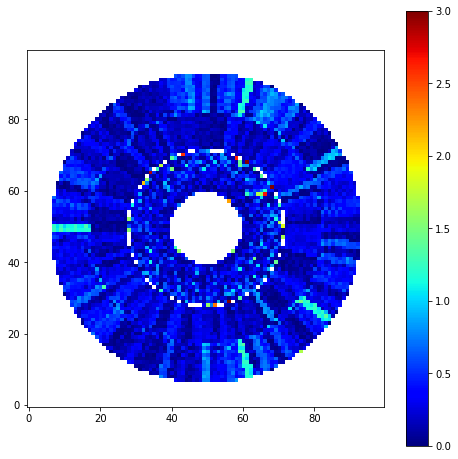

 >> Example 3
 >> Original image:


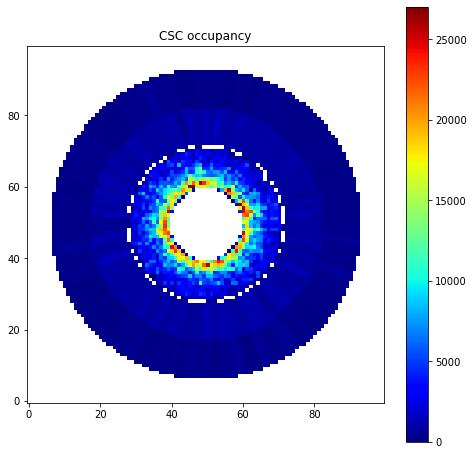

 >> AE-reco image:


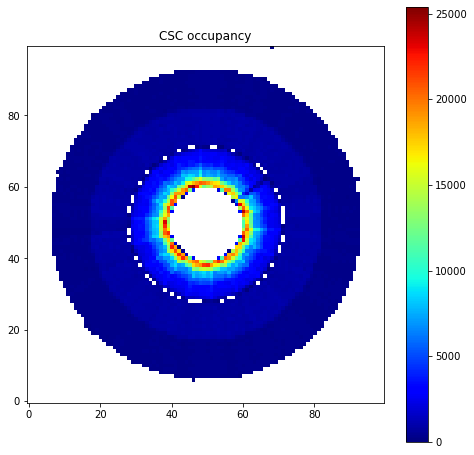

 >> Normalized loss map:


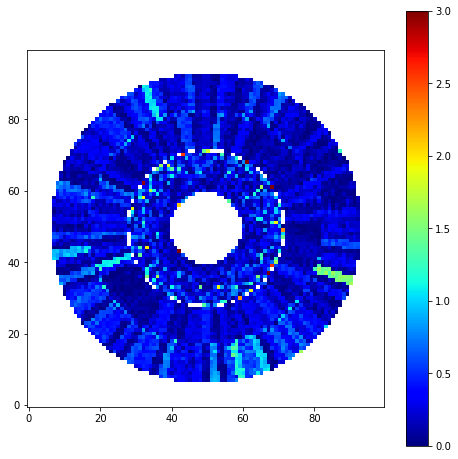

***** batch 6 *****
 >> Example 0
 >> Original image:


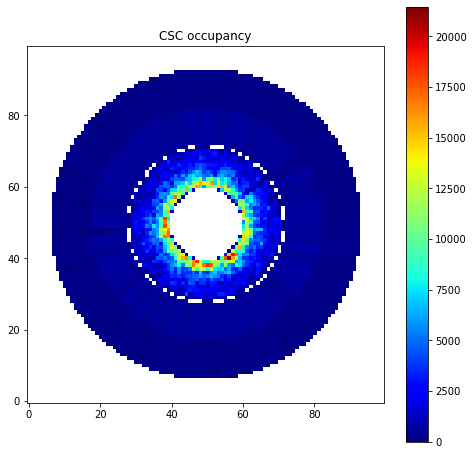

 >> AE-reco image:


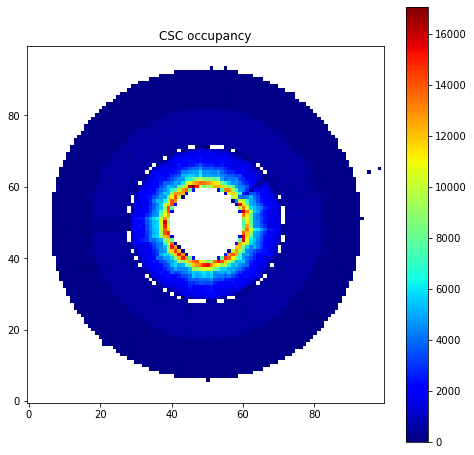

 >> Normalized loss map:


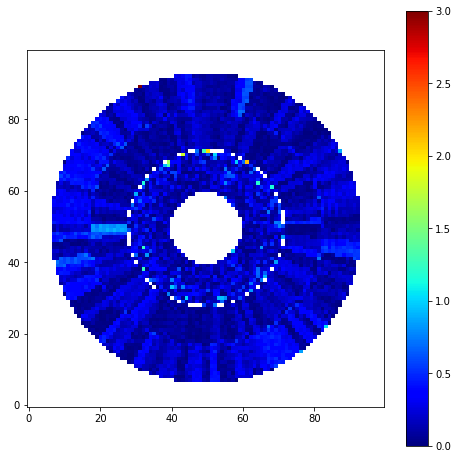

 >> Example 1
 >> Original image:


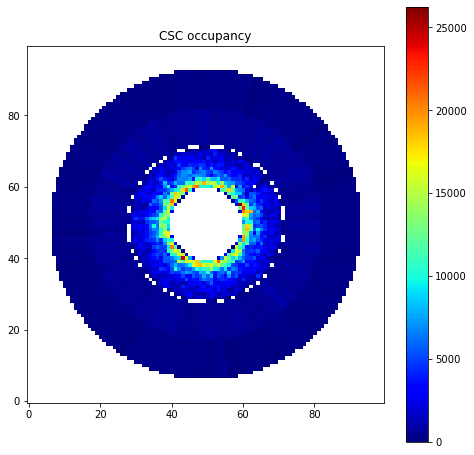

 >> AE-reco image:


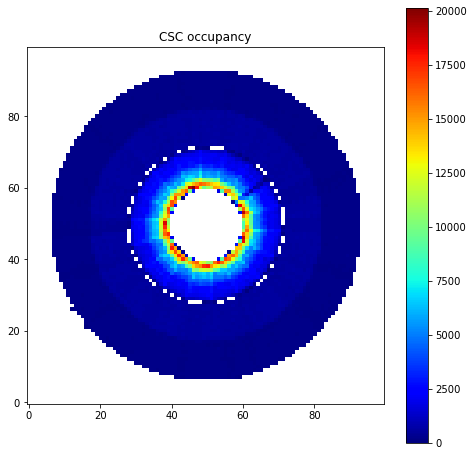

 >> Normalized loss map:


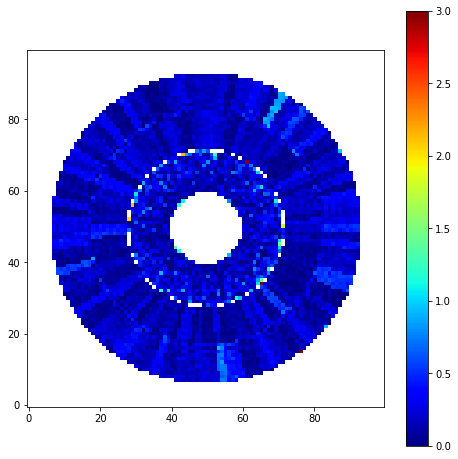

 >> Example 2
 >> Original image:


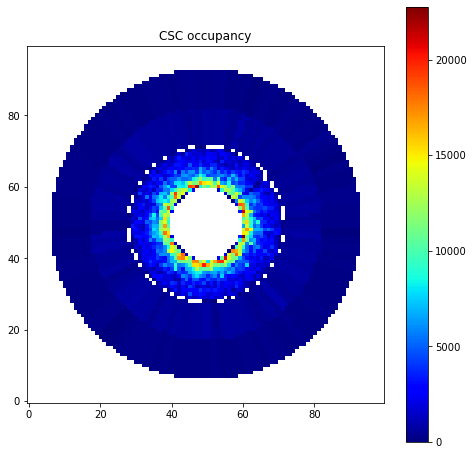

 >> AE-reco image:


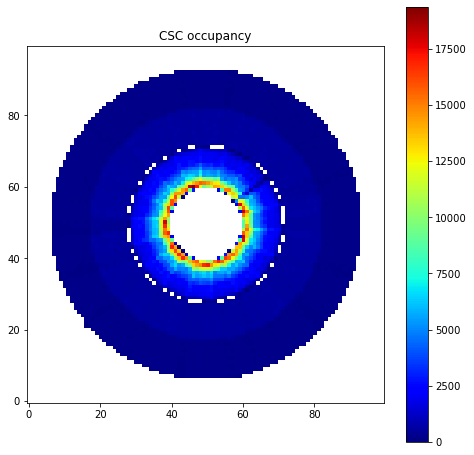

 >> Normalized loss map:


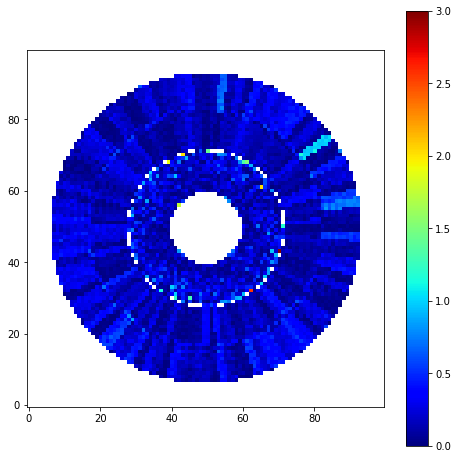

 >> Example 3
 >> Original image:


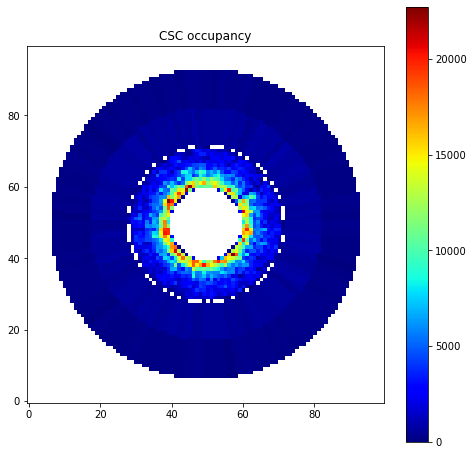

 >> AE-reco image:


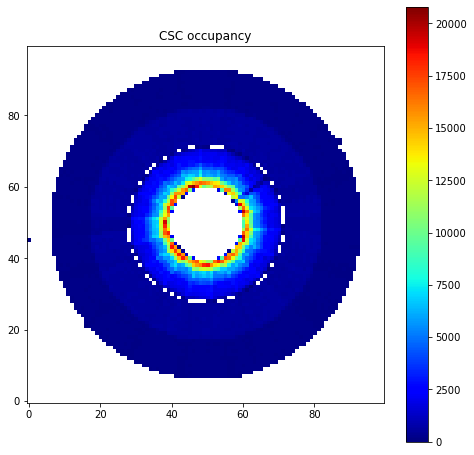

 >> Normalized loss map:


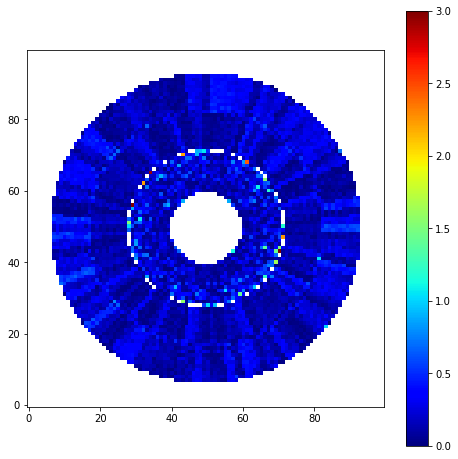

***** batch 7 *****
 >> Example 0
 >> Original image:


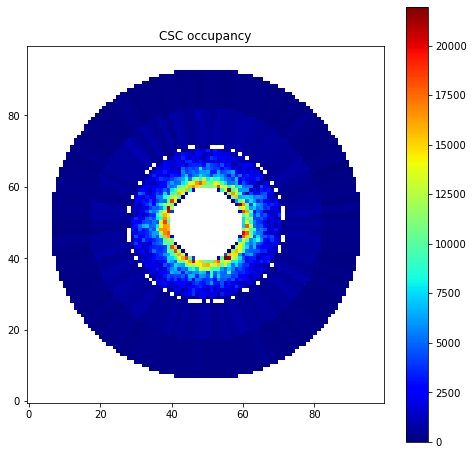

 >> AE-reco image:


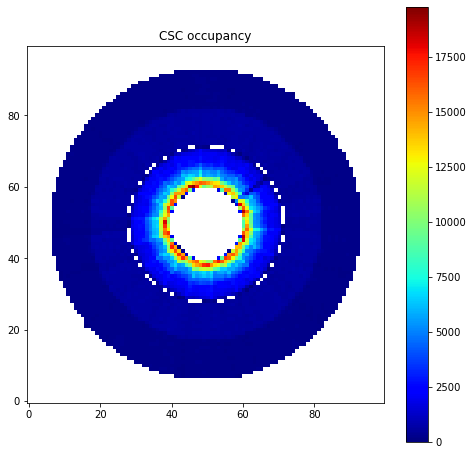

 >> Normalized loss map:


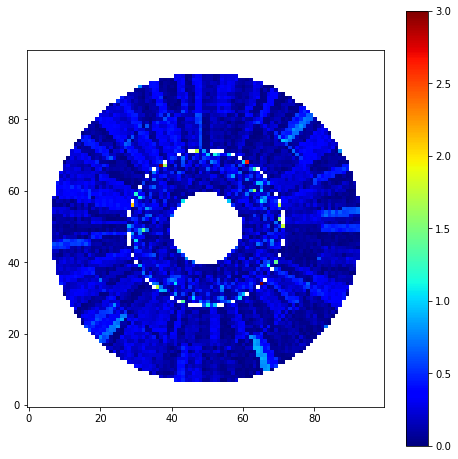

 >> Example 1
 >> Original image:


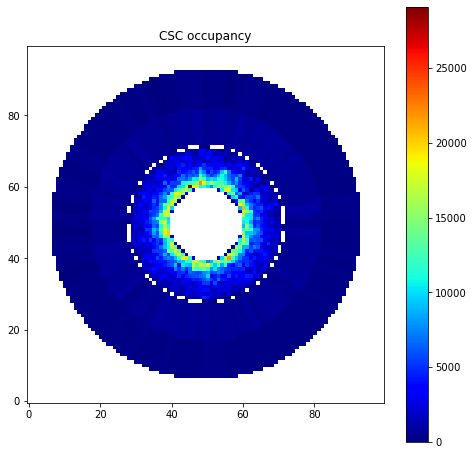

 >> AE-reco image:


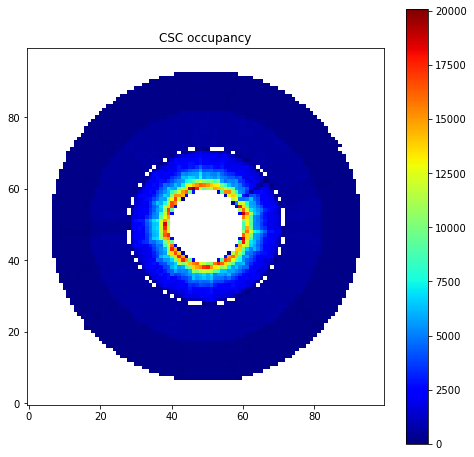

 >> Normalized loss map:


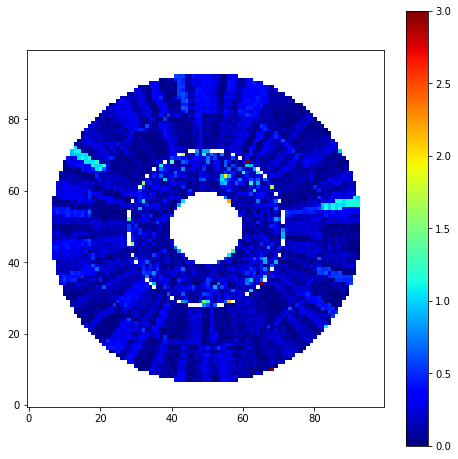

 >> Example 2
 >> Original image:


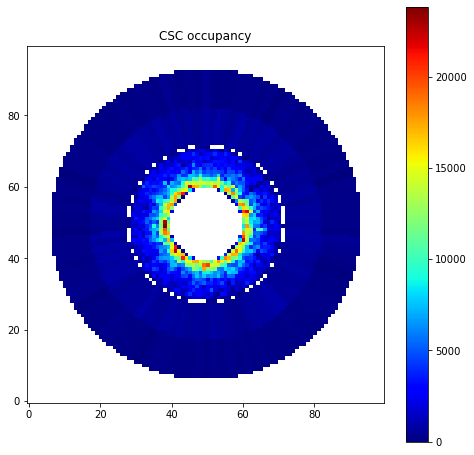

 >> AE-reco image:


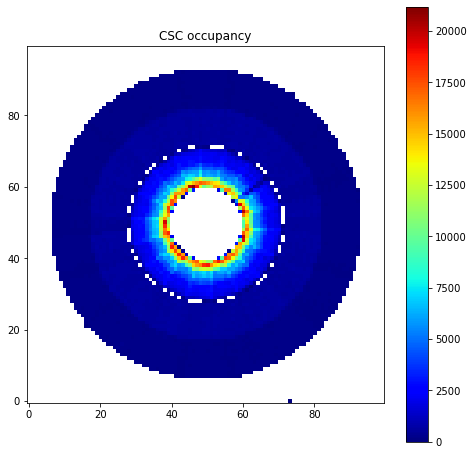

 >> Normalized loss map:


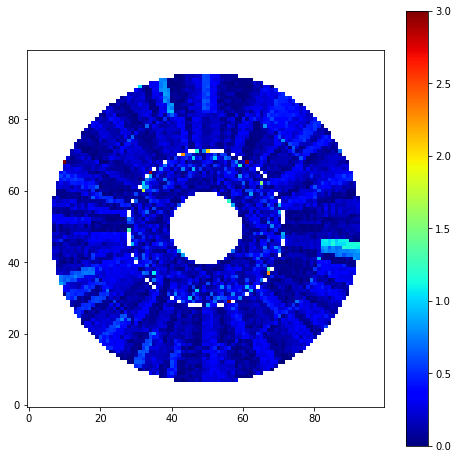

 >> Example 3
 >> Original image:


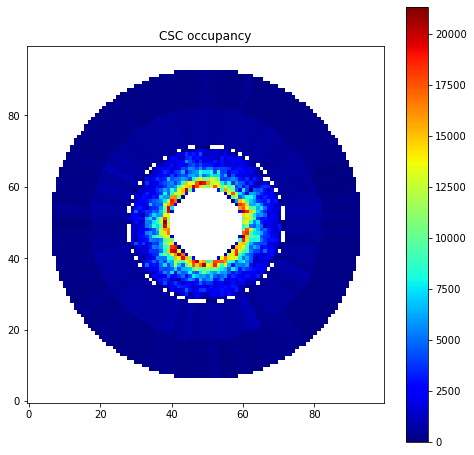

 >> AE-reco image:


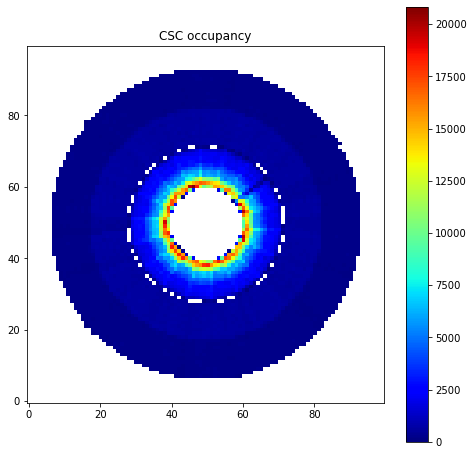

 >> Normalized loss map:


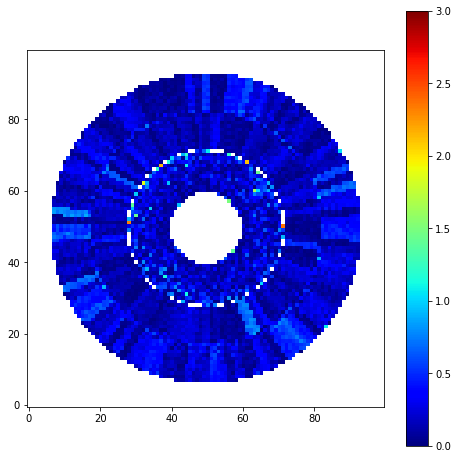

***** batch 8 *****
 >> Example 0
 >> Original image:


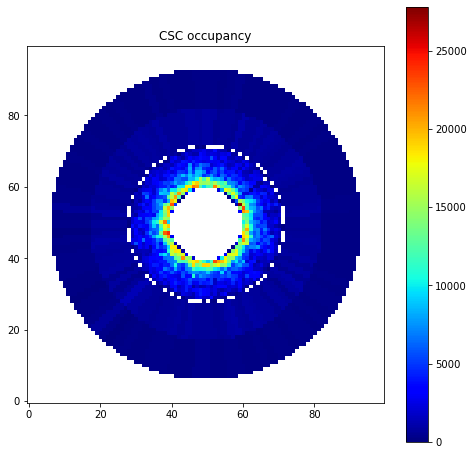

 >> AE-reco image:


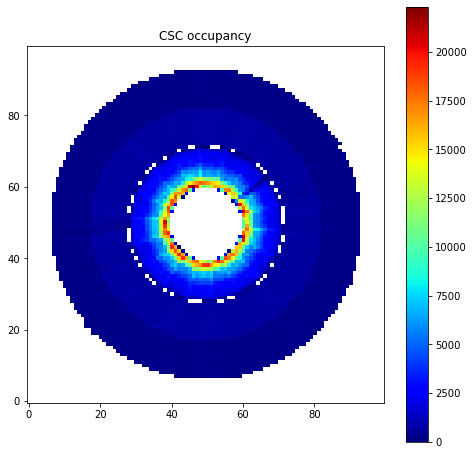

 >> Normalized loss map:


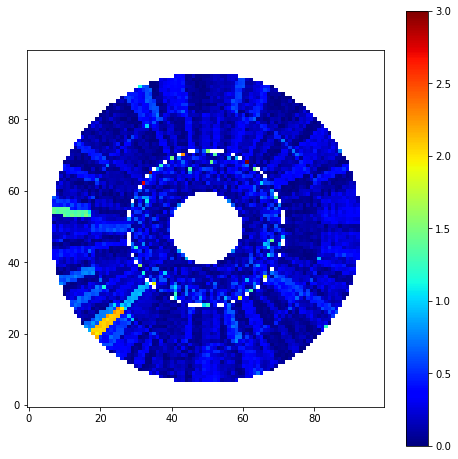

 >> Example 1
 >> Original image:


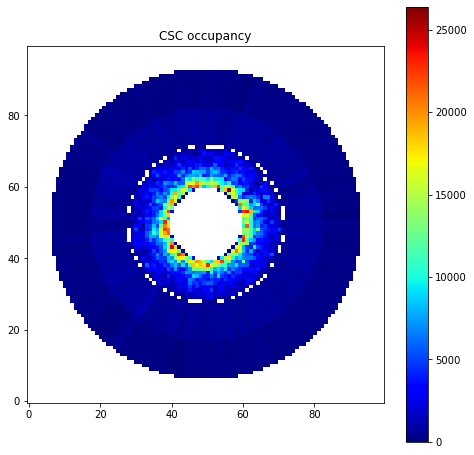

 >> AE-reco image:


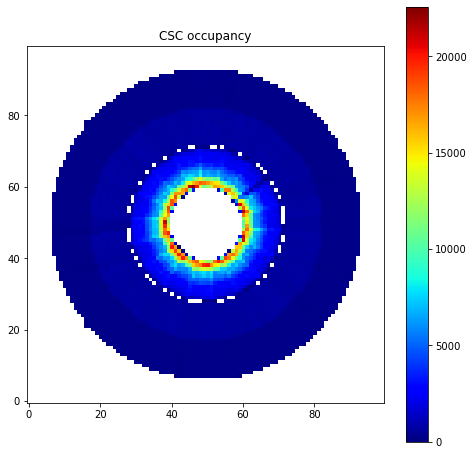

 >> Normalized loss map:


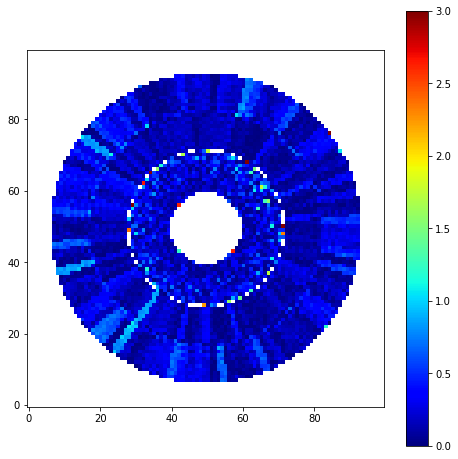

 >> Example 2
 >> Original image:


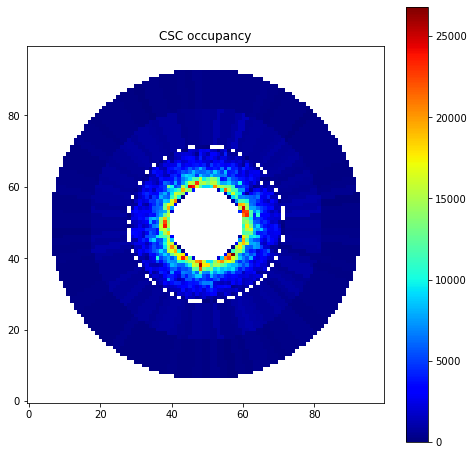

 >> AE-reco image:


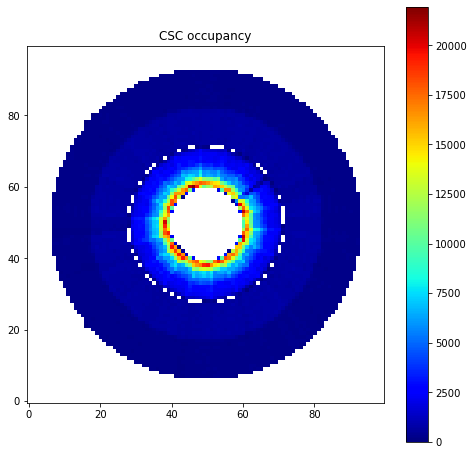

 >> Normalized loss map:


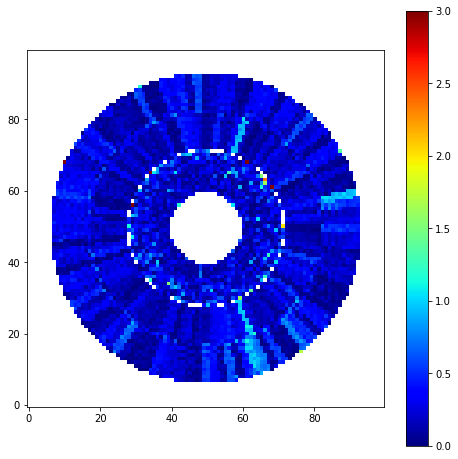

 >> Example 3
 >> Original image:


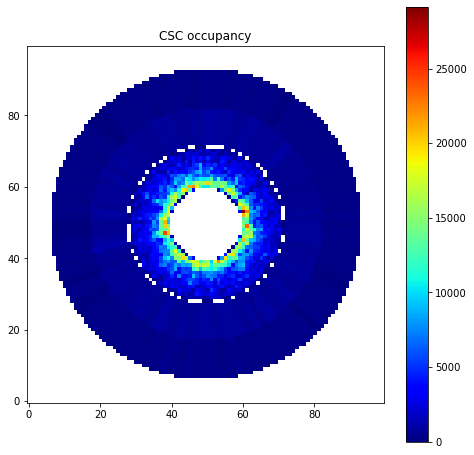

 >> AE-reco image:


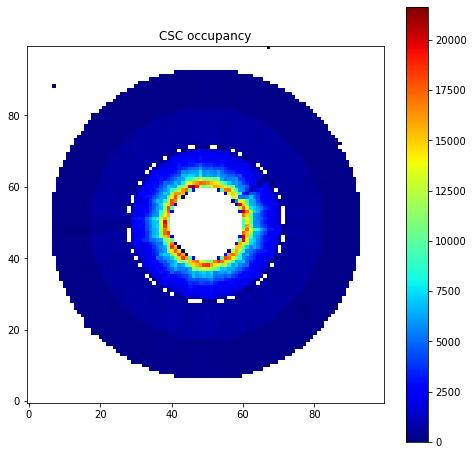

 >> Normalized loss map:


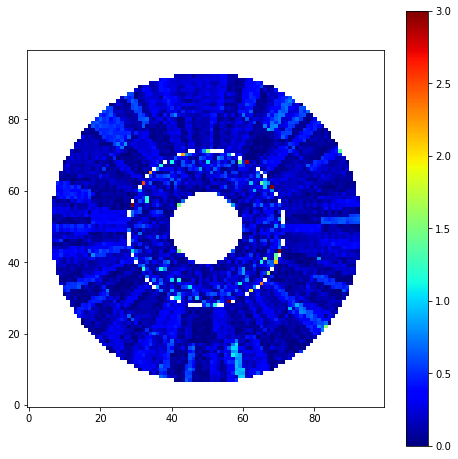

***** batch 9 *****
 >> Example 0
 >> Original image:


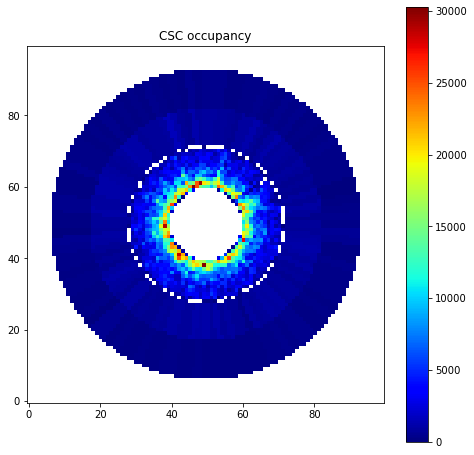

 >> AE-reco image:


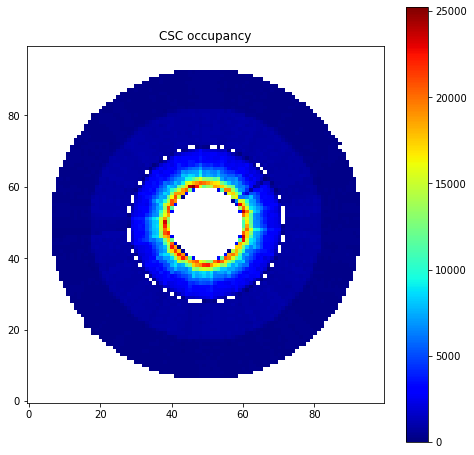

 >> Normalized loss map:


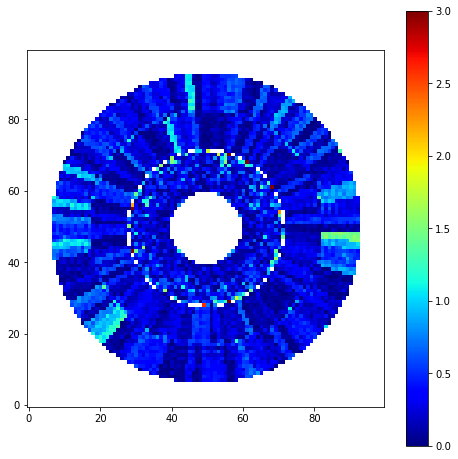

 >> Example 1
 >> Original image:


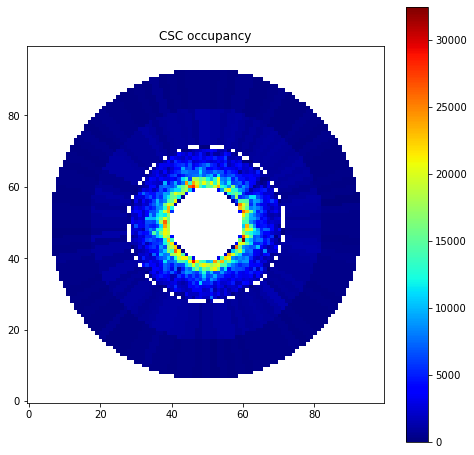

 >> AE-reco image:


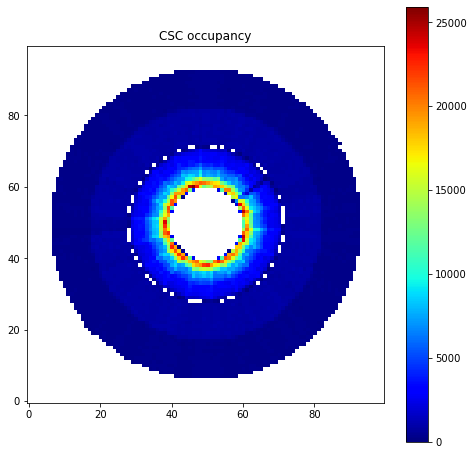

 >> Normalized loss map:


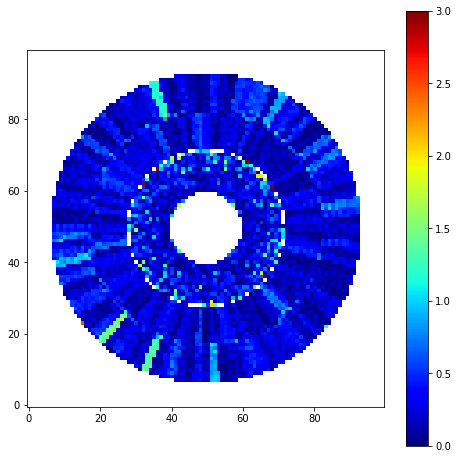

 >> Example 2
 >> Original image:


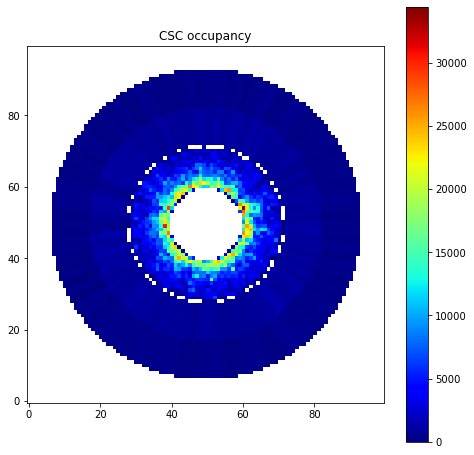

 >> AE-reco image:


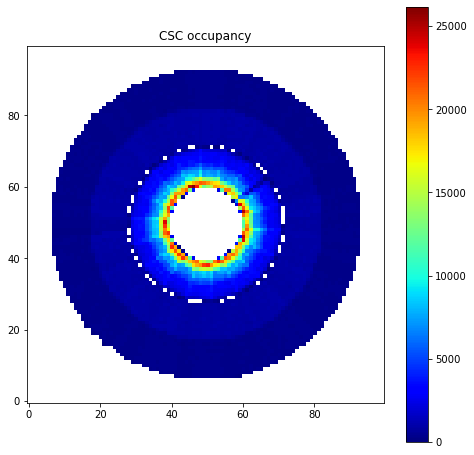

 >> Normalized loss map:


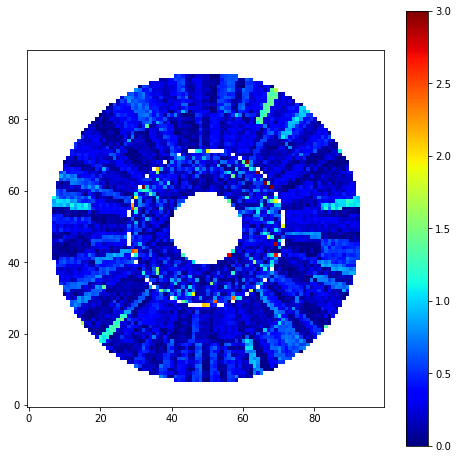

 >> Example 3
 >> Original image:


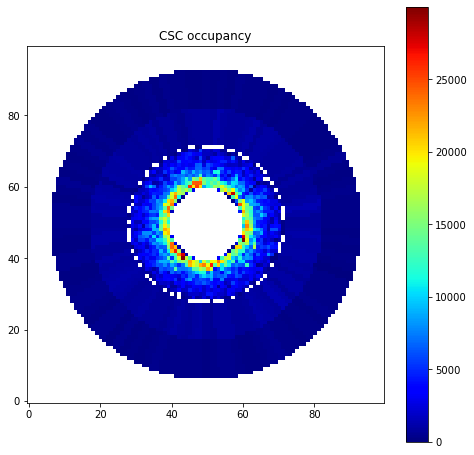

 >> AE-reco image:


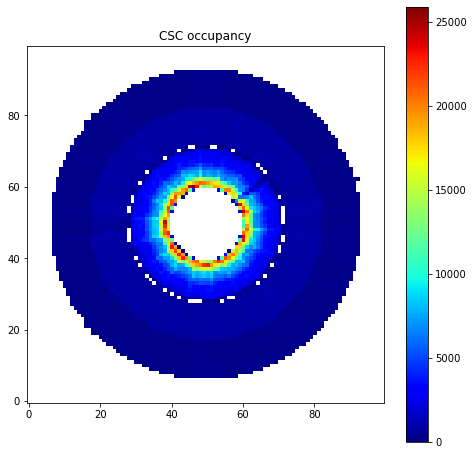

 >> Normalized loss map:


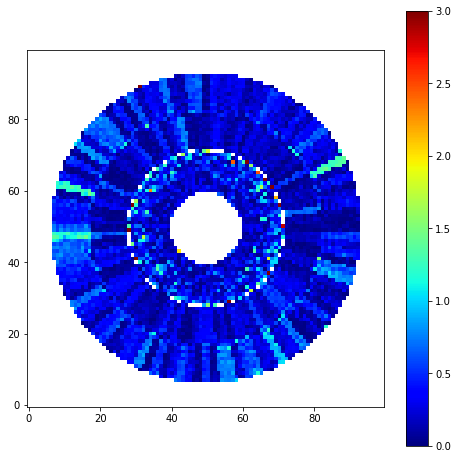

***** batch 10 *****
 >> Example 0
 >> Original image:


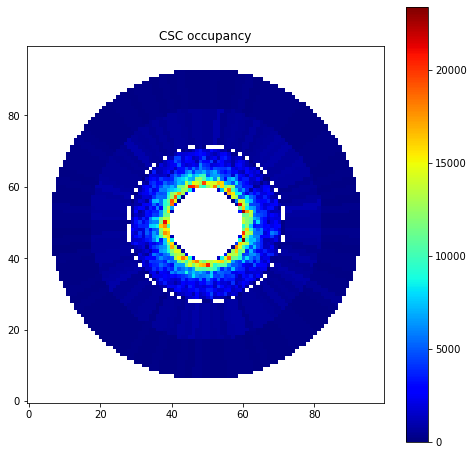

 >> AE-reco image:


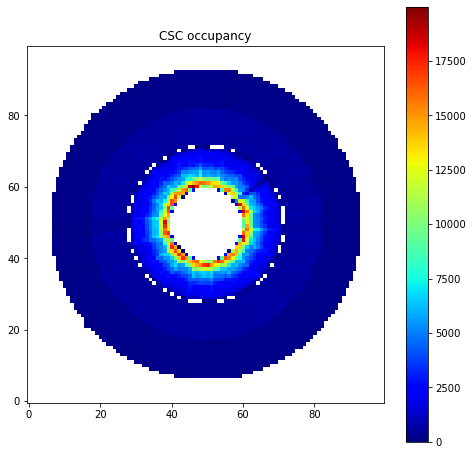

 >> Normalized loss map:


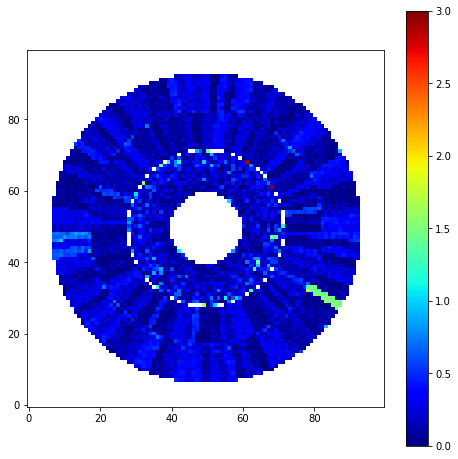

 >> Example 1
 >> Original image:


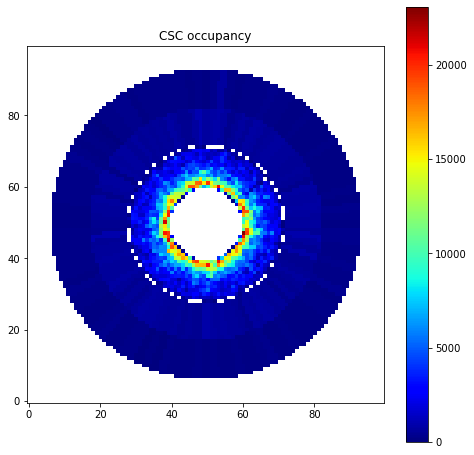

 >> AE-reco image:


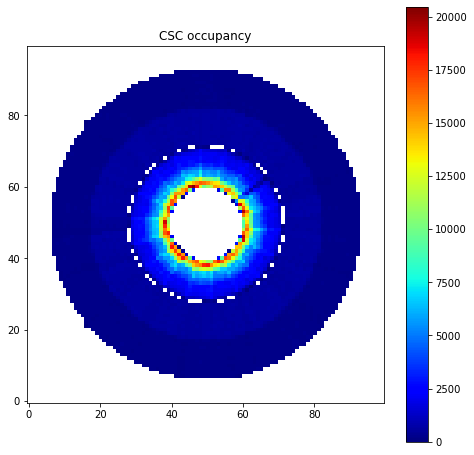

 >> Normalized loss map:


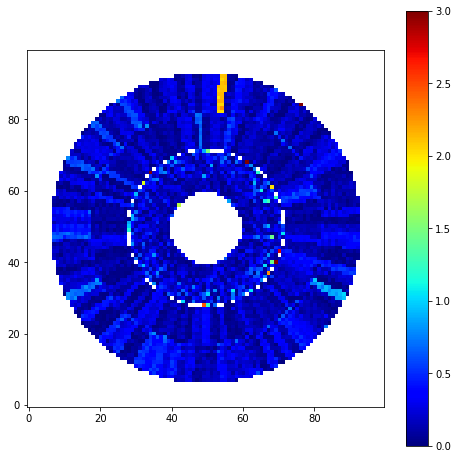

 >> Example 2
 >> Original image:


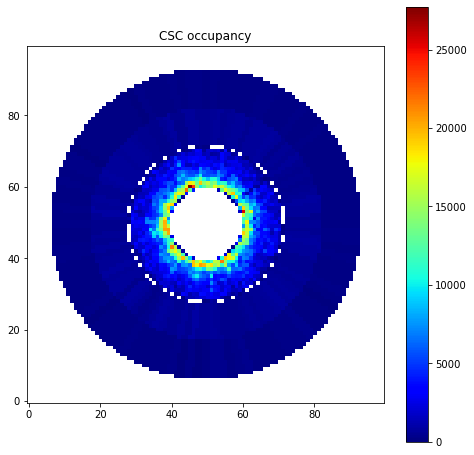

 >> AE-reco image:


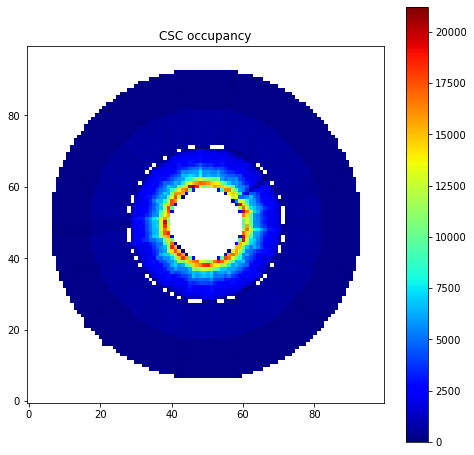

 >> Normalized loss map:


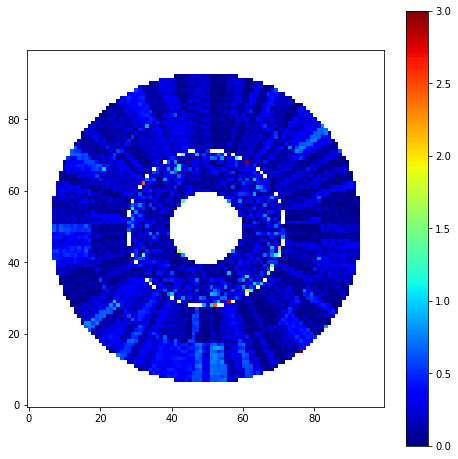

 >> Example 3
 >> Original image:


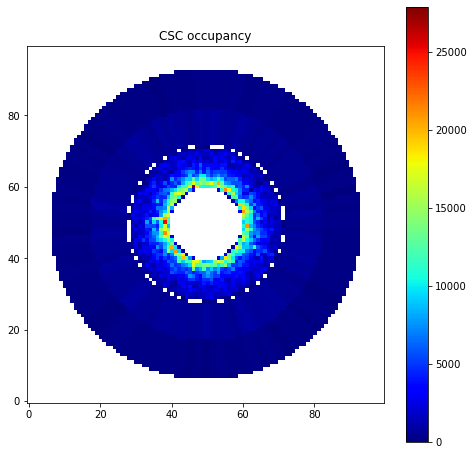

 >> AE-reco image:


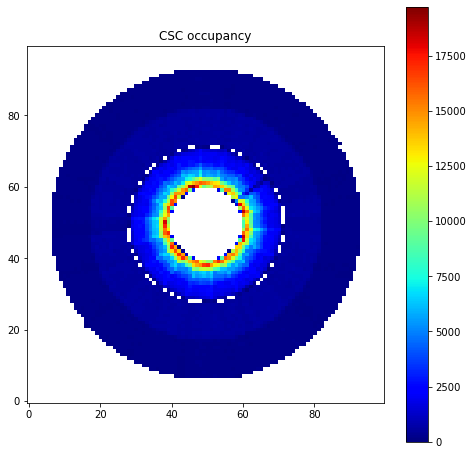

 >> Normalized loss map:


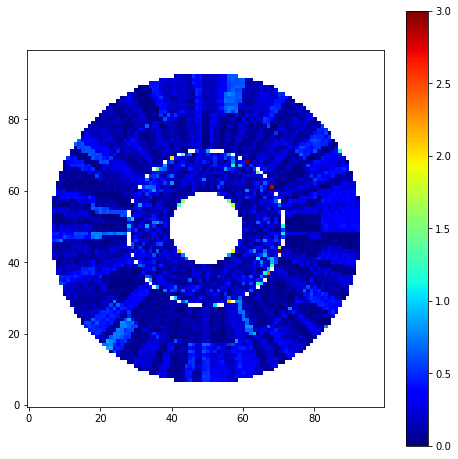

***** batch 11 *****
 >> Example 0
 >> Original image:


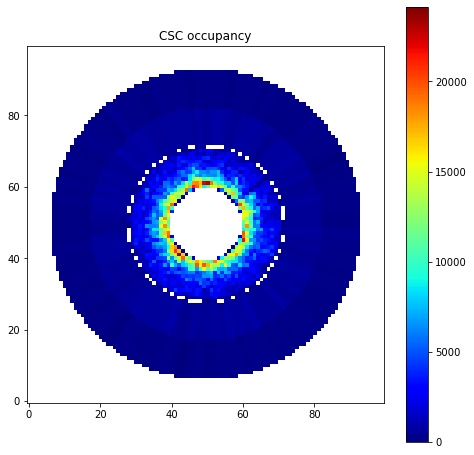

 >> AE-reco image:


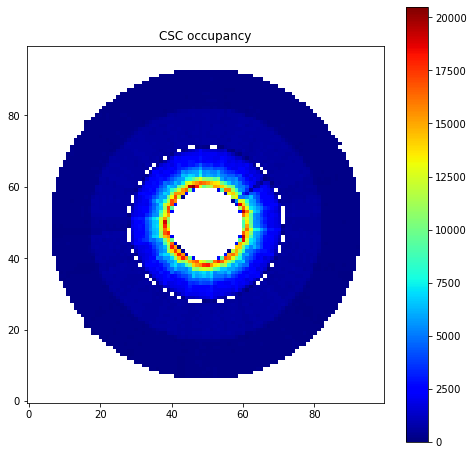

 >> Normalized loss map:


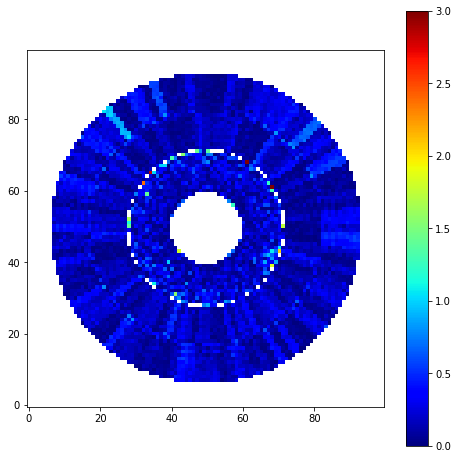

 >> Example 1
 >> Original image:


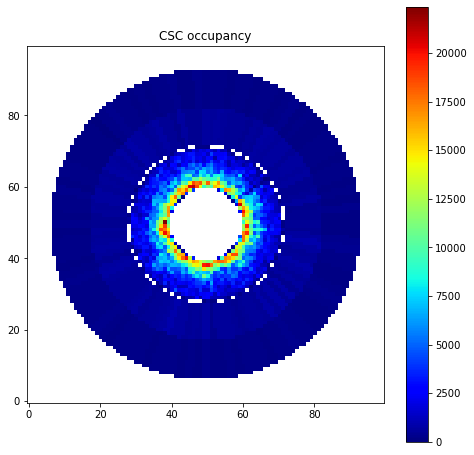

 >> AE-reco image:


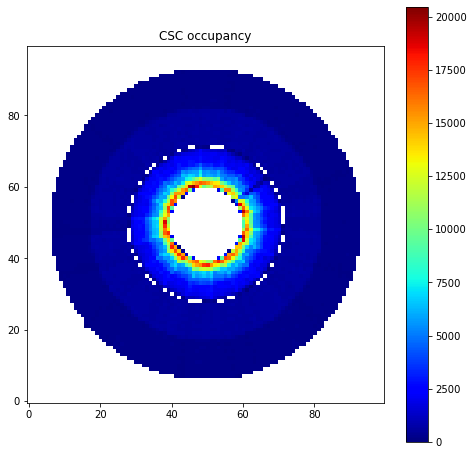

 >> Normalized loss map:


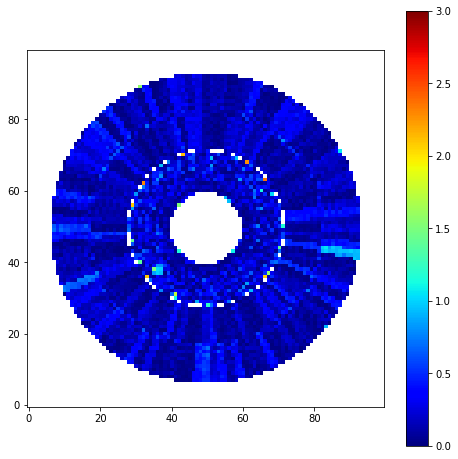

 >> Example 2
 >> Original image:


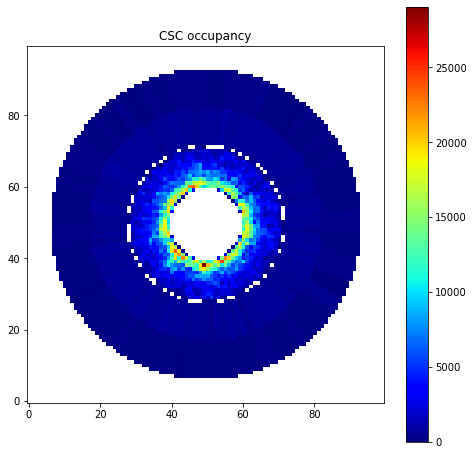

 >> AE-reco image:


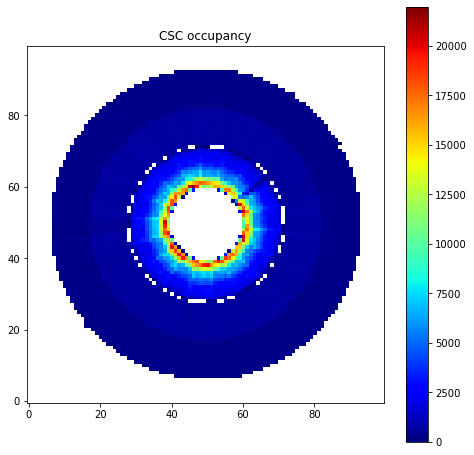

 >> Normalized loss map:


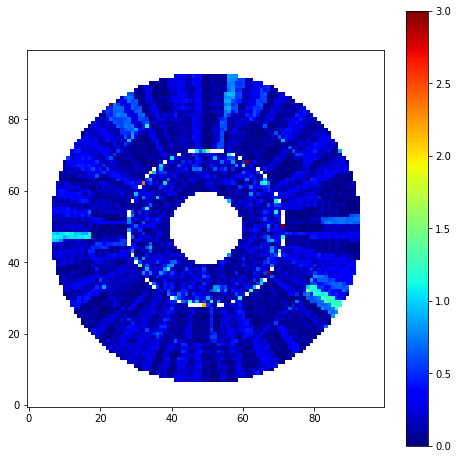

 >> Example 3
 >> Original image:


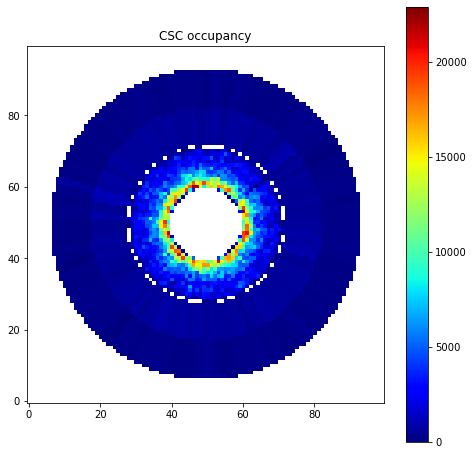

 >> AE-reco image:


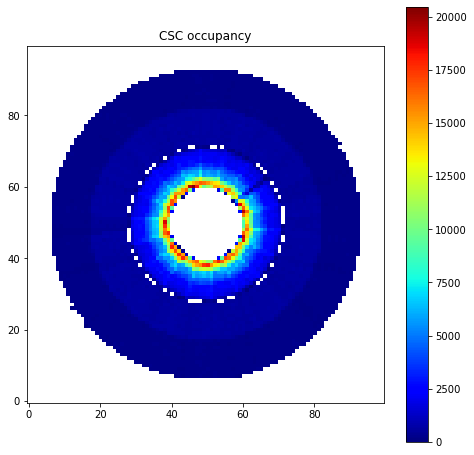

 >> Normalized loss map:


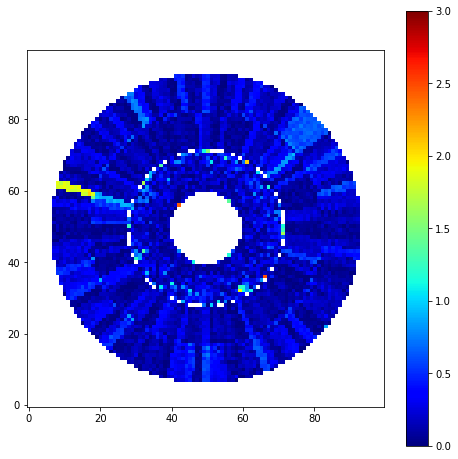

***** batch 12 *****
 >> Example 0
 >> Original image:


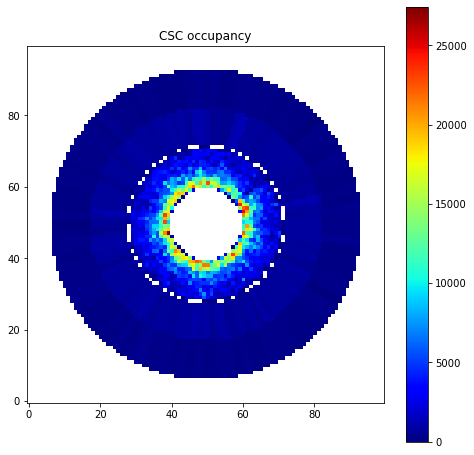

 >> AE-reco image:


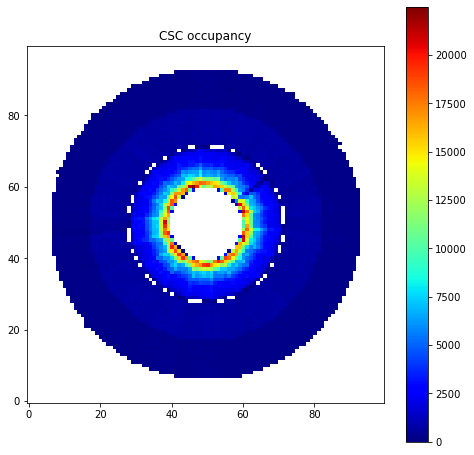

 >> Normalized loss map:


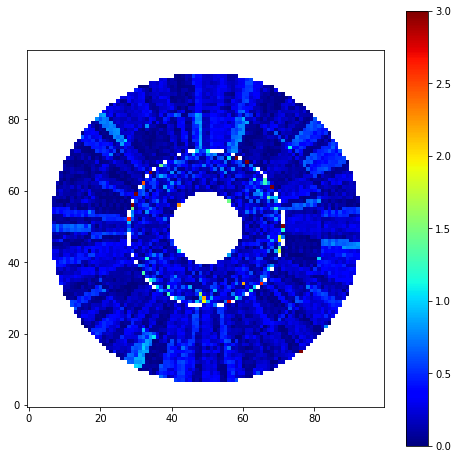

 >> Example 1
 >> Original image:


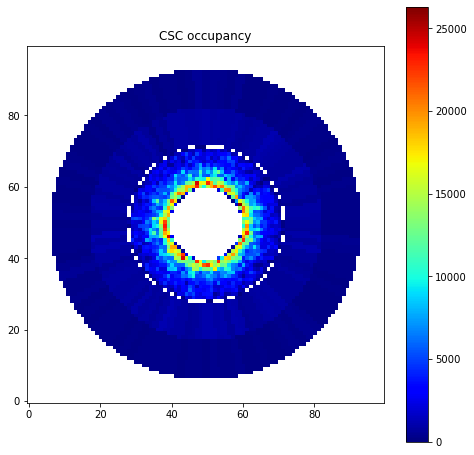

 >> AE-reco image:


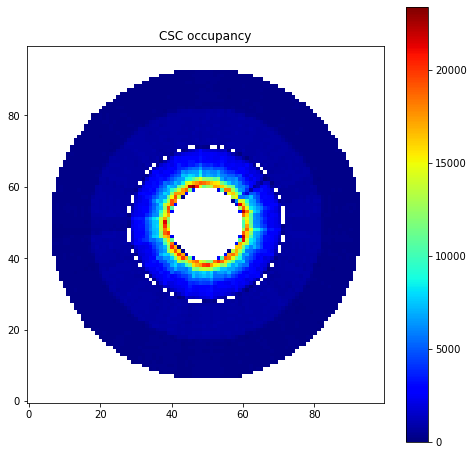

 >> Normalized loss map:


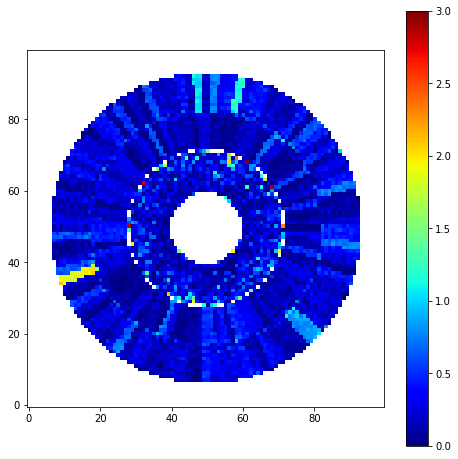

 >> Example 2
 >> Original image:


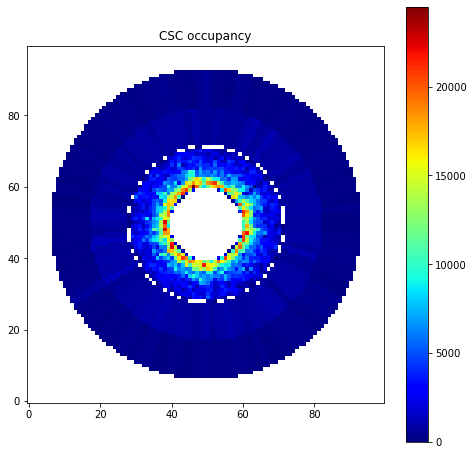

 >> AE-reco image:


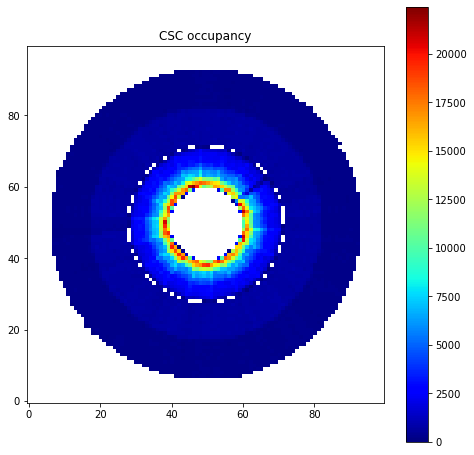

 >> Normalized loss map:


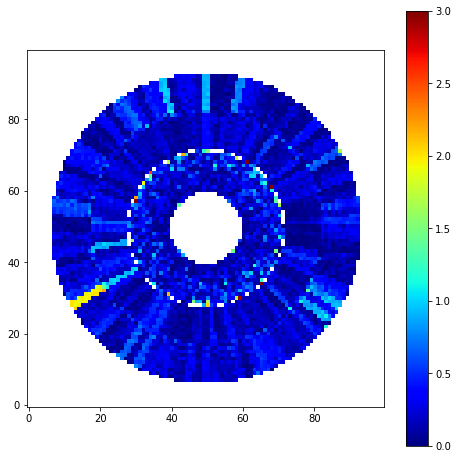

 >> Example 3
 >> Original image:


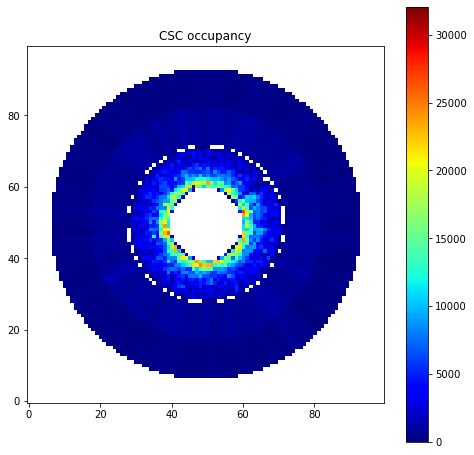

 >> AE-reco image:


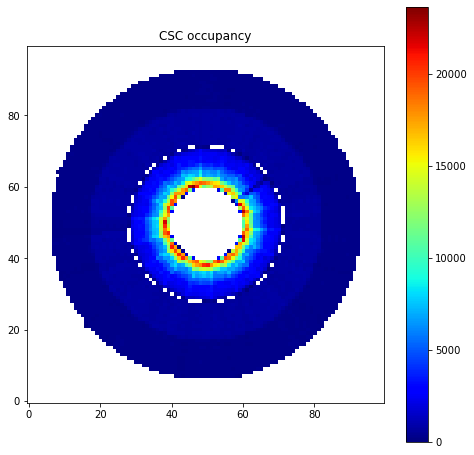

 >> Normalized loss map:


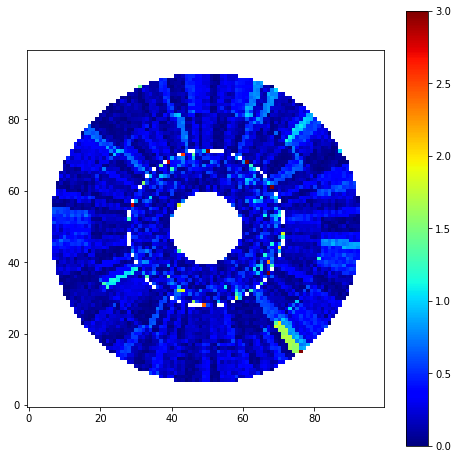

***** batch 13 *****
 >> Example 0
 >> Original image:


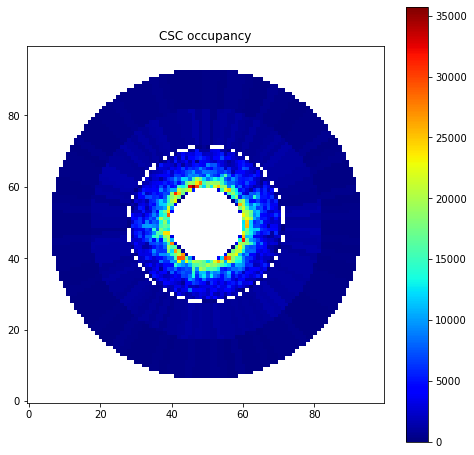

 >> AE-reco image:


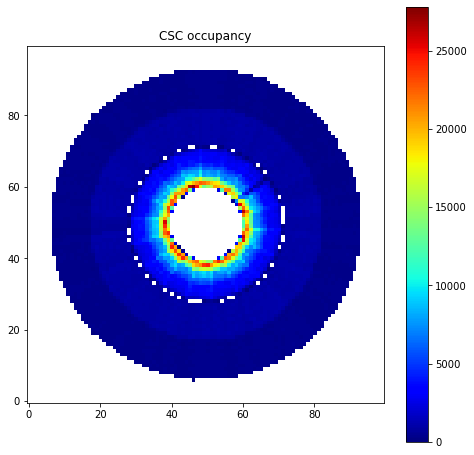

 >> Normalized loss map:


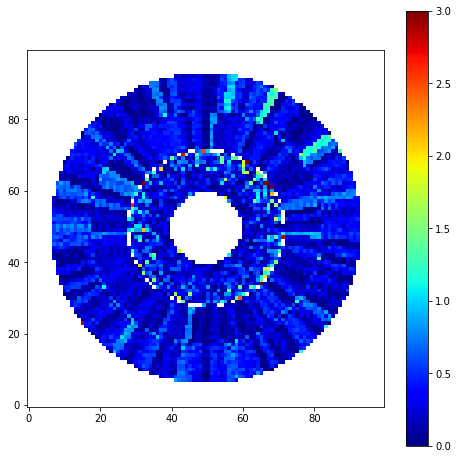

 >> Example 1
 >> Original image:


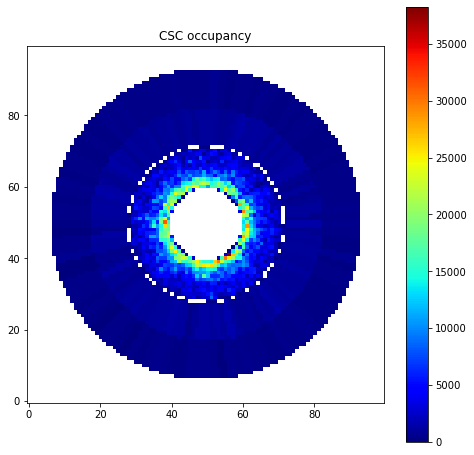

 >> AE-reco image:


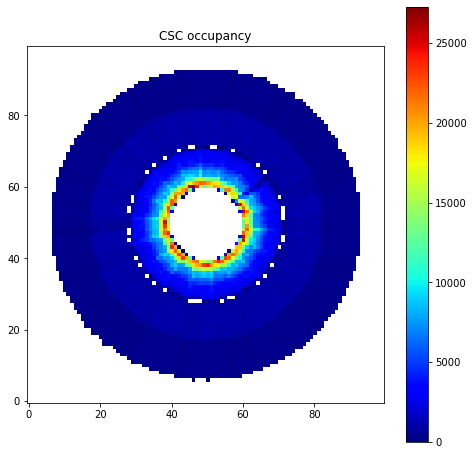

 >> Normalized loss map:


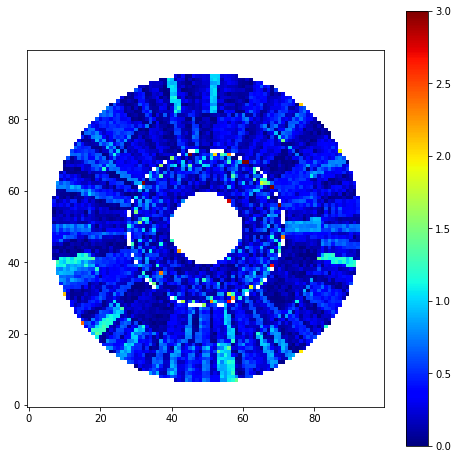

 >> Example 2
 >> Original image:


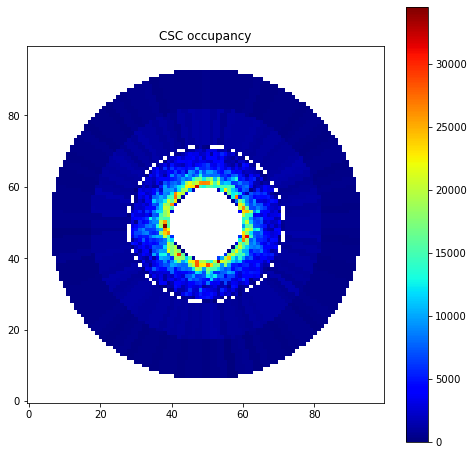

 >> AE-reco image:


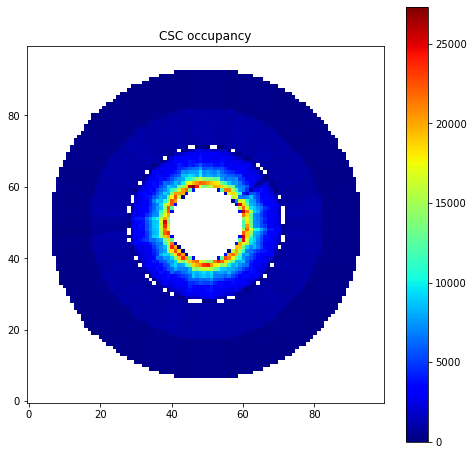

 >> Normalized loss map:


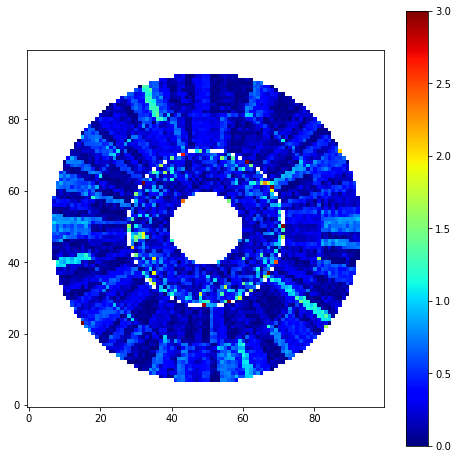

 >> Example 3
 >> Original image:


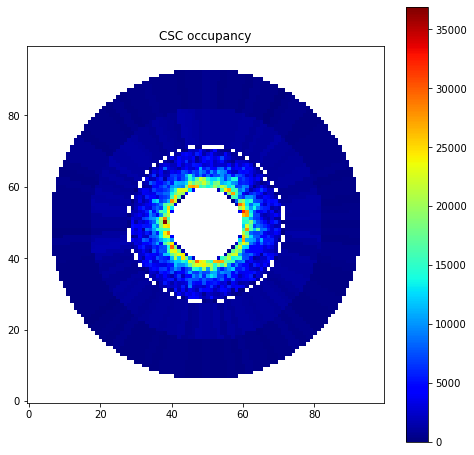

 >> AE-reco image:


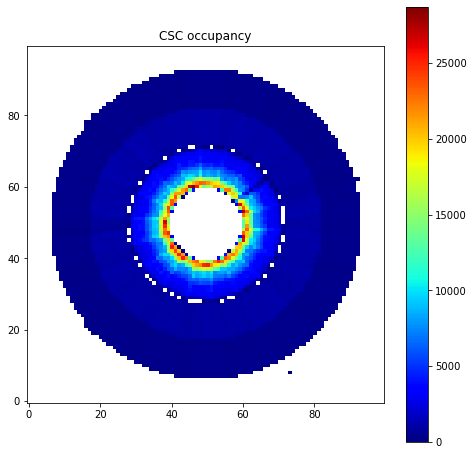

 >> Normalized loss map:


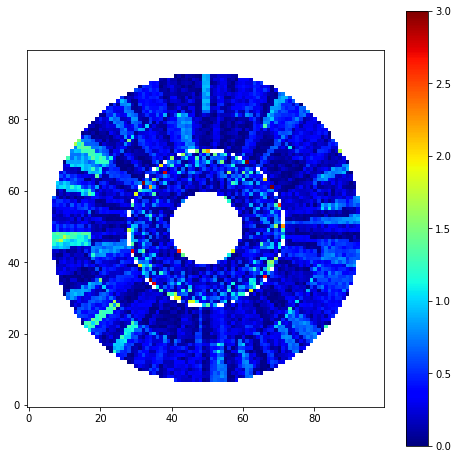

In [9]:
for i, img in enumerate(validation_loader):
    img = img.to(device)
    #img = img*(img<10).float()
    reco_img = ae(img)
    print(f"***** batch {i} *****")
    #k=0
    #if True:
    for k in range(4):
        print(f" >> Example {k}")
        print(' >> Original image:')
        Show2Dimg(img[k][0].cpu().numpy())
        print(' >> AE-reco image:')
        Show2Dimg(reco_img[k][0].detach().cpu().numpy())
        print(' >> Normalized loss map:')
        img_loss = F.l1_loss(reco_img[k], img[k], reduction='none')[0].detach().cpu().numpy()
        #Show2Dimg(img_loss/mean_matrix)
        out = img_loss/mean_matrix
        fig = plt.figure(figsize =(8, 8))
        plt.imshow(out, cmap=plt.cm.jet, vmin=0, vmax=3)
        plt.gca().invert_yaxis()
        plt.colorbar()
        plt.show()